# Coursework 2: Generative Models

## Instructions

### Submission
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), please refer to the 4 GPU options detailed in the logistics lecture. Some additional useful pointers:
* PaperSpace [guide if you need more compute](https://hackmd.io/@afspies/S1stL8Qnt)
* Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
* Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
* Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is Monday, 26 Feb by 6 pm** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
!pip install -q torch torchvision altair seaborn
!pip install tqdm
!git clone -q https://github.com/afspies/icl_dl_cw2_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 1.7 MB/s eta 0:00:00a 0:00:01
fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


In [1]:
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm
import json
import matplotlib.pyplot as plt
from glob import glob

Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
# Initialization Cell
WORKING_ENV = 'LABS' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = 'aap120' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_cw2_repo_path = 'dl_cw2/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{dl_cw2_repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw2/' # You may want to change this
    data_path = f'/vol/bitbucket/{USERNAME}/dl/'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
           )
elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'

elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points.

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [4]:
# Necessary Hyperparameters
num_epochs = 25
learning_rate = 1e-3
batch_size = 128
latent_dim = 50 # Choose a value for the size of the latent space

# Additional Hyperparameters
beta = 2
betas = [0, 0.5, 1, 2, 5, 10]

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round()
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [5]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [9]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Encoder
        self.conv_1 = nn.Conv2d(1, 16, 3)
        self.batch_norm_1 = nn.BatchNorm2d(16)

        self.conv_2 = nn.Conv2d(16, 32, 3)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(32, 64, 3)

        self.linear_1 = nn.Linear(22*22*64, 128)
        self.linear_2 = nn.Linear(128, 64)

        self.linear_mu = nn.Linear(64, latent_dim)
        self.linear_logvar = nn.Linear(64, latent_dim)

        #Decoder
        self.linear_3 = nn.Linear(latent_dim, 64)
        self.linear_4 = nn.Linear(64, 128)
        self.linear_5 = nn.Linear(128, 22*22*64)

        self.transpose_conv_1 = nn.ConvTranspose2d(64, 32, 3)

        self.transpose_conv_2 = nn.ConvTranspose2d(32, 16, 3)

        self.transpose_conv_3 = nn.ConvTranspose2d(16, 1, 3)


        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = x.to(device)

        x = F.relu(self.batch_norm_1(self.conv_1(x)))
        x = F.relu(self.batch_norm_2(self.conv_2(x)))
        x = F.relu(self.conv_3(x))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))

        mu, logvar = self.linear_mu(x), self.linear_logvar(x)

        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        sigma = torch.exp(logvar / 2)

        epsilon = torch.randn_like(sigma)

        z = mu + sigma * epsilon

        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        z = F.relu(self.linear_3(z))
        z = F.relu(self.linear_4(z))
        z = F.relu(self.linear_5(z))
        z = z.view(-1, 64, 22, 22)

        z = F.relu(self.transpose_conv_1(z))
        z = F.relu(self.transpose_conv_2(z))
        z = self.transpose_conv_3(z)

        return torch.sigmoid(z)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reconstructed = self.decode(z)

        return x_reconstructed, mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 8033925
VAE(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (linear_1): Linear(in_features=30976, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_mu): Linear(in_features=64, out_features=50, bias=True)
  (linear_logvar): Linear(in_features=64, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=64, bias=True)
  (linear_4): Linear(in_features=64, out_features=128, bias=True)
  (linear_5): Linear(in_features=128, out_features=30976, bias=True)
  (transpose_conv_1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (transpose_conv_2): C

---

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [8]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        loss_function = nn.BCELoss(reduction='sum')
        reconstruction_loss = loss_function(recon_x, x)
        kl_divergence_loss = torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar)) / 2

        total_loss = reconstruction_loss - beta * kl_divergence_loss

        return reconstruction_loss, kl_divergence_loss, total_loss
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
    
def evaluate_model(model, epoch, current_beta):
    model.eval()
    
    reconstruction_loss_sum = 0
    kl_divergence_loss_sum = 0
    total_loss_sum = 0
    
   
    with tqdm.tqdm(loader_test, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(loader_test):  

            data = data.to(device)

            x_reconstructed, mu, logvar = model.forward(data)

            reconstruction_loss, kl_divergence_loss, loss = loss_function_VAE(x_reconstructed, data, mu, logvar, current_beta)

            reconstruction_loss_sum += reconstruction_loss.item() / len(data)
            kl_divergence_loss_sum += kl_divergence_loss.item() / len(data)
            total_loss_sum += loss.item() / len(data)

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}, Test")
                tepoch.set_postfix(loss=loss.item()/len(data))
    
    
    return reconstruction_loss_sum / (batch_idx + 1), kl_divergence_loss_sum / (batch_idx + 1), total_loss_sum / (batch_idx + 1)
        
def train_vae(current_beta, model=None, optimizer=None, del_model=False):
    if del_model:
        model = VAE(latent_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    train_losses = []

    test_losses = []

    # <- You may wish to add logging info here
    for epoch in range(num_epochs):
        
        model.train()
        
        reconstruction_loss_sum = 0
        kl_divergence_loss_sum = 0
        total_loss_sum = 0
        

        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):  
            
                #######################################################################
                #                       ** START OF YOUR CODE **
                #######################################################################

                data = data.to(device)

                x_reconstructed, mu, logvar = model.forward(data)

                reconstruction_loss, kl_divergence_loss, loss = loss_function_VAE(x_reconstructed, data, mu, logvar, current_beta)

                reconstruction_loss_sum += reconstruction_loss.item() / len(data)
                kl_divergence_loss_sum += kl_divergence_loss.item() / len(data)
                total_loss_sum += loss.item() / len(data)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #######################################################################
                #                       ** END OF YOUR CODE **
                #######################################################################

                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}, Train")
                    tepoch.set_postfix(loss=loss.item()/len(data))
        
        
        train_reconstruction_loss = reconstruction_loss_sum / (batch_idx + 1)
        train_kl_divergence_loss = kl_divergence_loss_sum / (batch_idx + 1) 
        train_total_loss = total_loss_sum / (batch_idx + 1)   

        test_reconstruction_loss, test_kl_divergence_loss, test_total_loss = evaluate_model(model, epoch, current_beta)

        
        # Loss curve data collection code
        
        train_losses.append({'reconstruction_loss': train_reconstruction_loss,
                            'kl_divergence_loss': train_kl_divergence_loss,
                            'total_loss': train_total_loss})
        
        
        
        test_losses.append({'reconstruction_loss': test_reconstruction_loss,
                            'kl_divergence_loss': test_kl_divergence_loss,
                            'total_loss': test_total_loss})
        
        # End of loss curve data collection code
                    
        # save the model
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    f'{content_path}/plots/vae/VAE_model_{current_beta}.pth')
    if del_model:
        del(model)

    return train_losses, test_losses

def save_vae_loss_curve(beta, train, array):
    loss_curves_path = f'{content_path}/plots/vae/loss_curves/{train}_losses_beta_{beta}'

    with open(f'{loss_curves_path}.json', 'w') as outfile:
        json.dump(array, outfile)

In [9]:
for current_beta in betas:
    train_losses, test_losses = train_vae(current_beta=current_beta, del_model=True)   
    save_vae_loss_curve(current_beta, "train", train_losses)
    save_vae_loss_curve(current_beta, "test", test_losses)    

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 24, Test:   0%|          | 0/79 [00:00<?, ?batch/s, loss=185]


In [29]:
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses, test_losses = train_vae(current_beta=beta, model=model, optimizer= optimizer, del_model=False) 

Epoch 0, Train:   0%|          | 0/469 [00:00<?, ?batch/s, loss=556]

Epoch 24, Test:   0%|          | 0/79 [00:01<?, ?batch/s, loss=118]


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [30]:
# Any code for your explanation here (you may not need to use this cell)

**YOUR ANSWER**

As seen in the equation presented above, the Beta VAE loss is made up of the difference between 2 terms, the reconstruction loss and the KL divergence. A beta weighting coefficient is applied to the latter of these two terms.

The reconstruction loss component measures the difference between the image provided as input and the image that is reconstructed from the latent representation. Because of this, and looking at commonly used metrics, we faced a choice between using mean squared error (MSE) or binary cross entropy (BCE) loss. There is strong theoretical evidence that BCE is particularly effective, especially when there is a class imbalance, but requires the data to be binarised, taking values of 0s or 1s. Our outputs are in the form of gray-scale images of handwritten digits, with black backgrounds and mostly white text. Therefore, our pixel values (post normalisation) lie between 0 and 1, with the majority of them being black (the background). Because of the nature of this output data domain, a simple preprocessing step can be applied to round each pixel to either a 0 or a 1, making it suitable for BCE. This has the added effect of sharpening the input images. This is the approach we followed, due to the suitability of our data to be preprocessed in this way, and the advantages of BCE on imbalanced classes.

The KL divergence component of our loss acts to penalise the deviation of our learnt distribution from a prior distribution. In our case, the chosen prior distribution on the latent space was a Gaussian distribution, N(0, 1). The KL divergence term, when minimised, allows for the disentanglement of the latent space, which allows each dimension to correspond to a meaningful feature of the data. This makes the latent space easier to interpret.


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

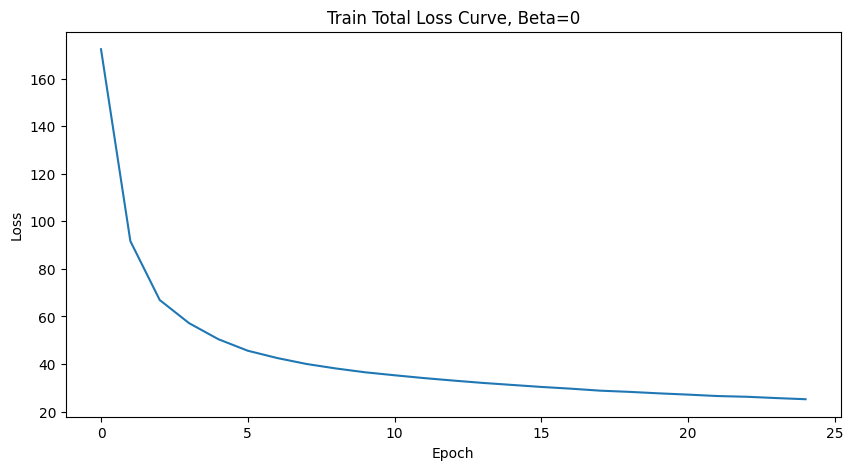

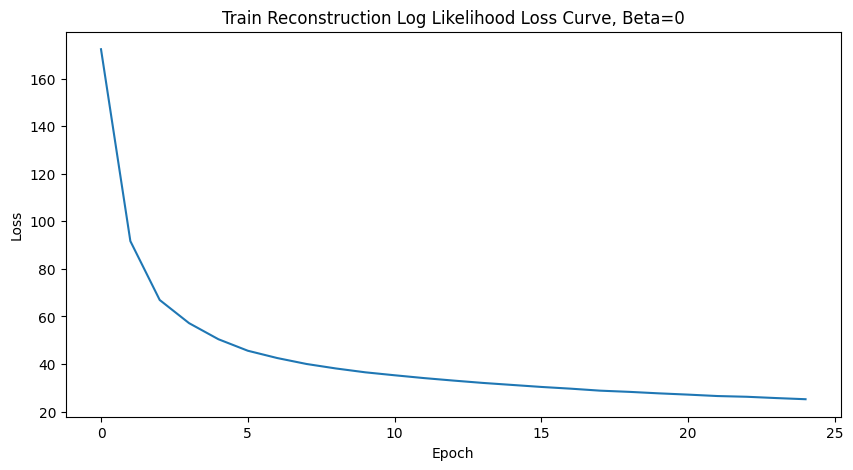

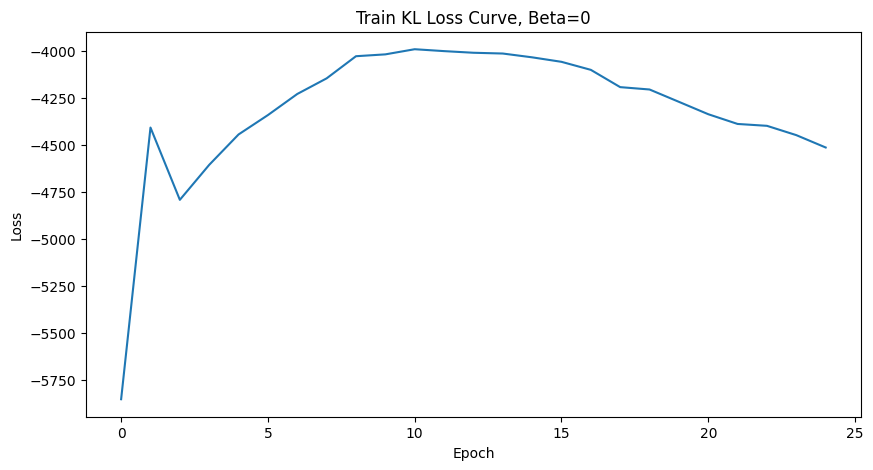

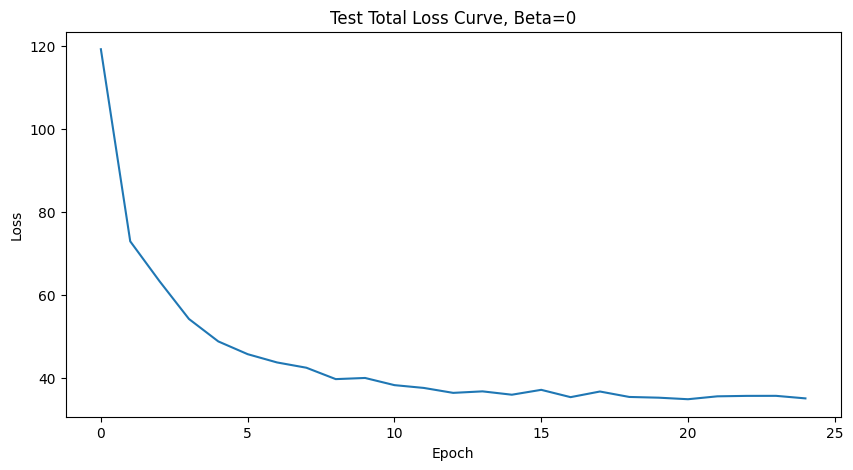

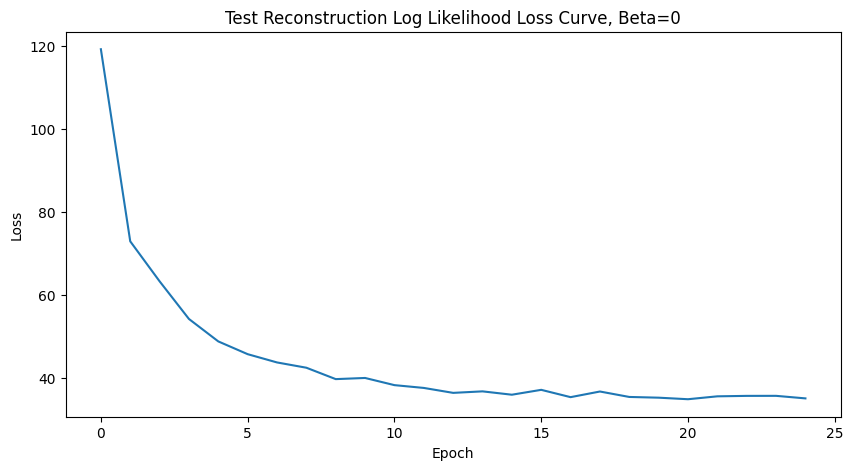

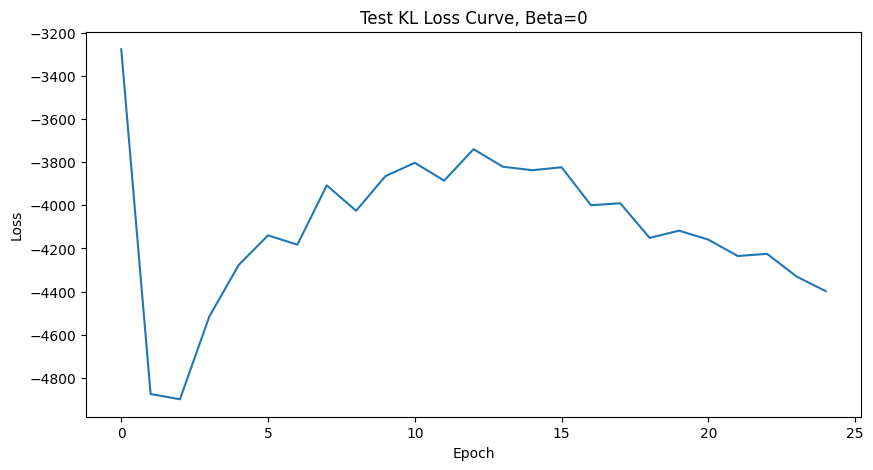

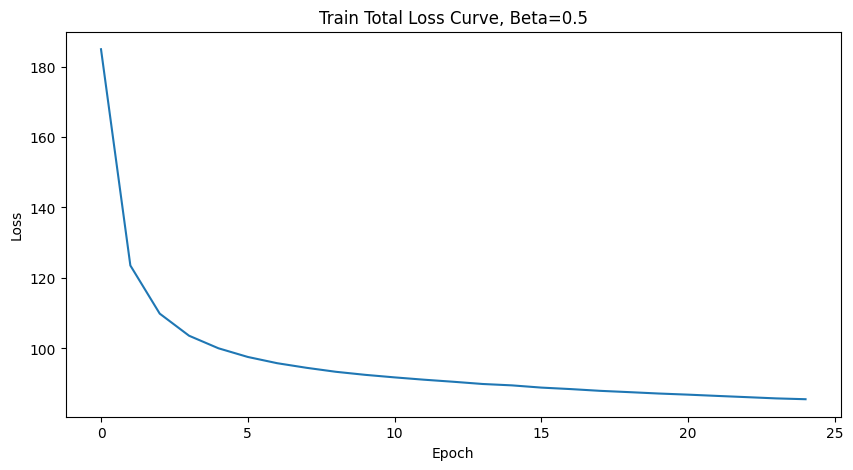

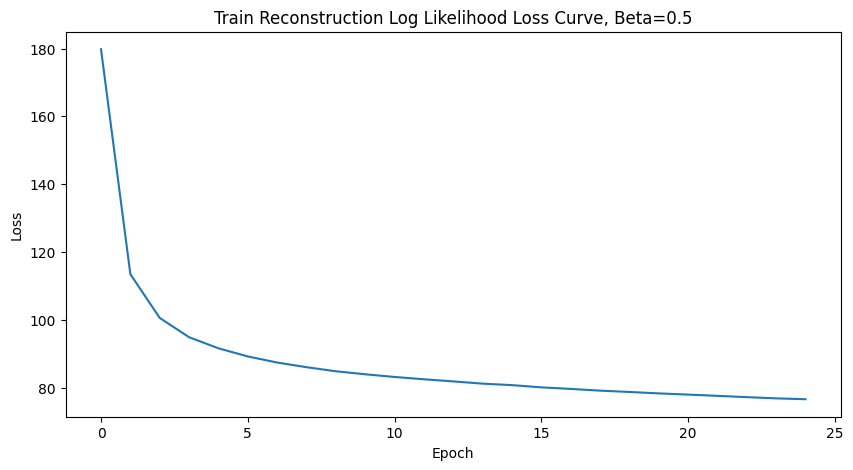

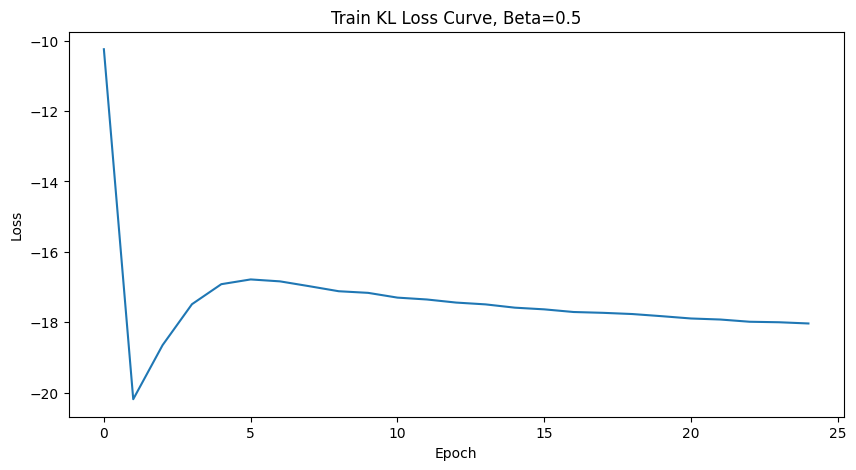

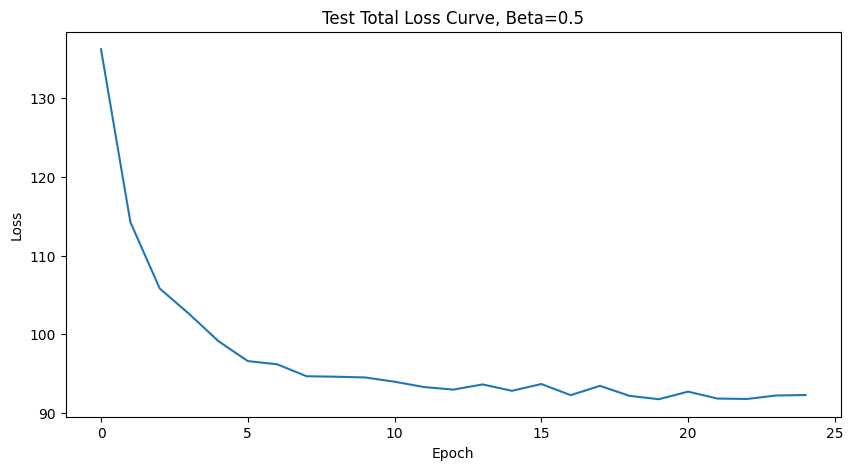

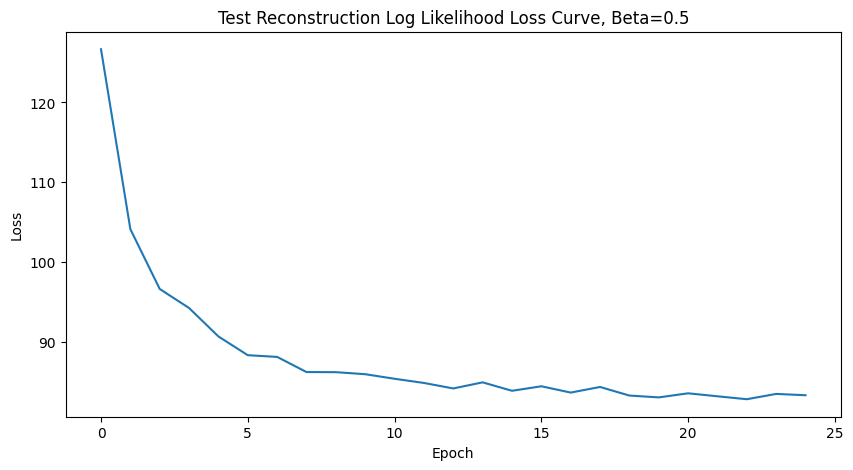

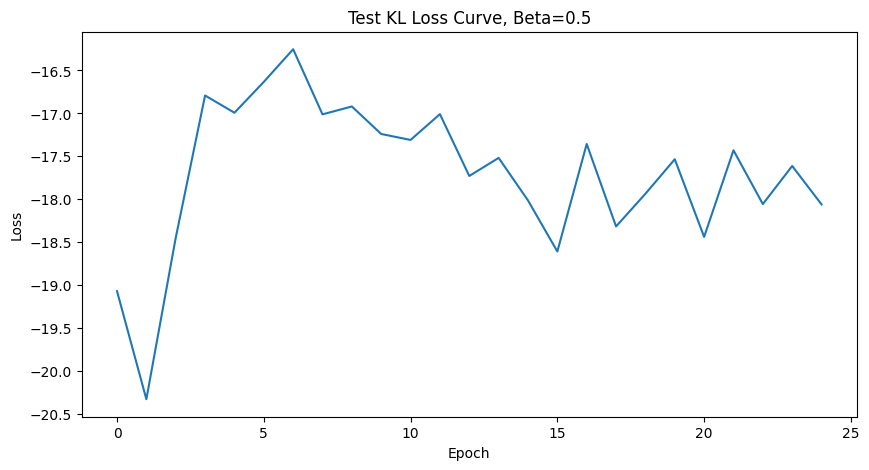

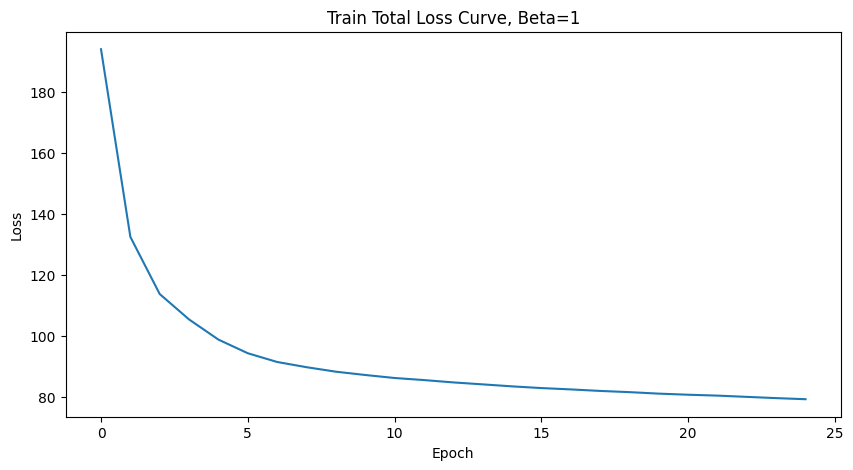

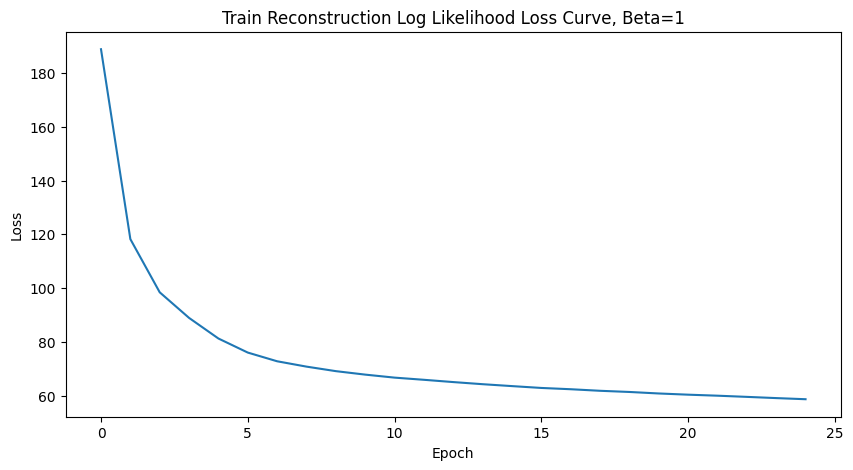

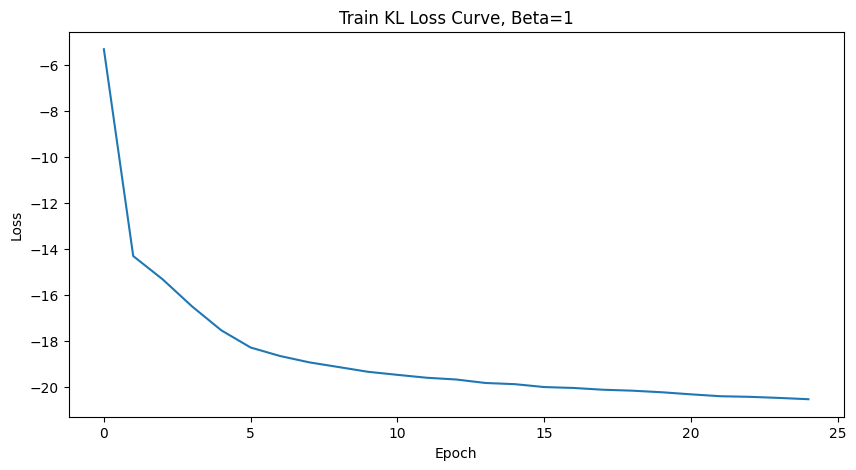

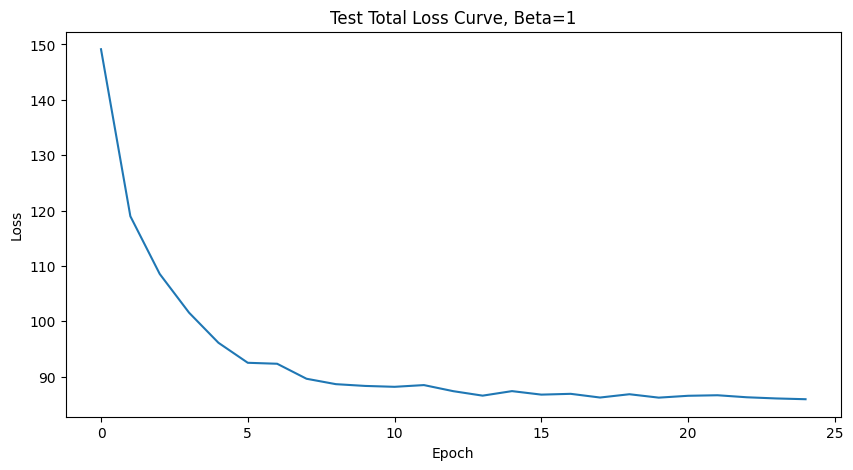

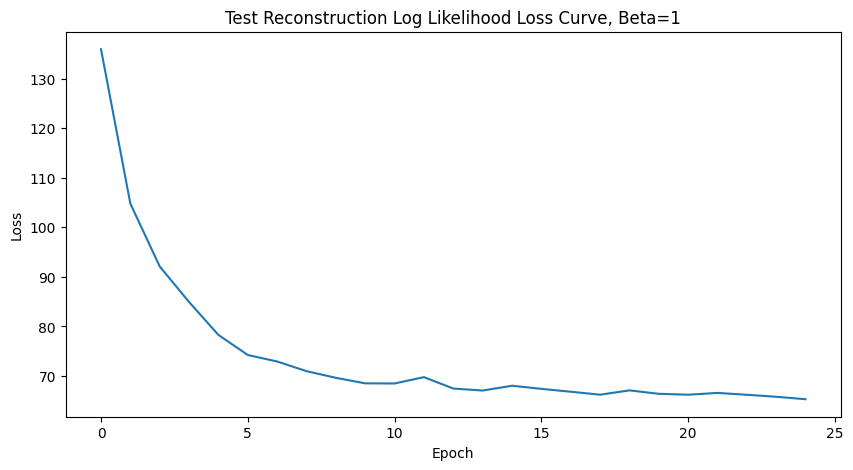

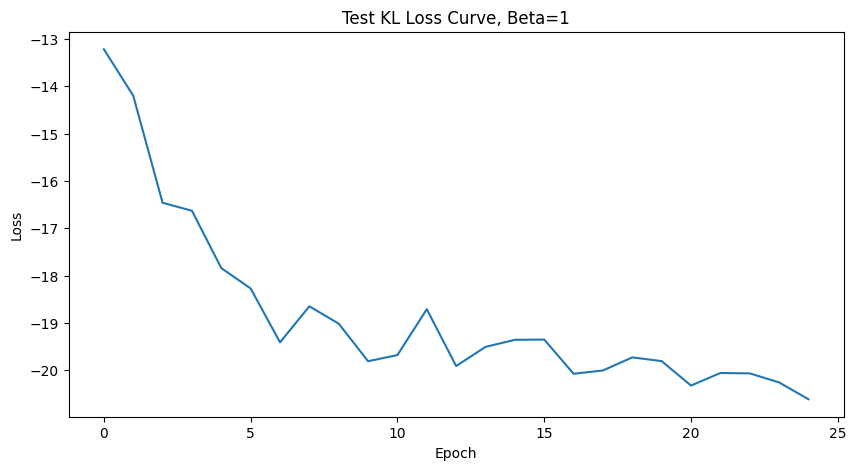

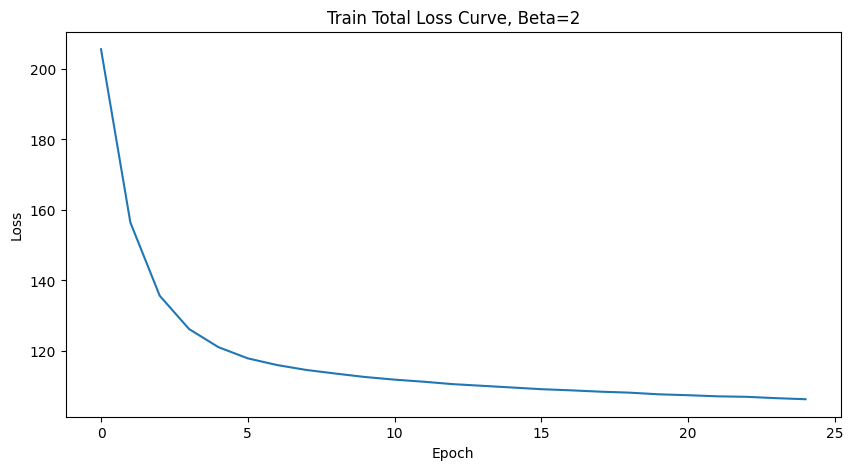

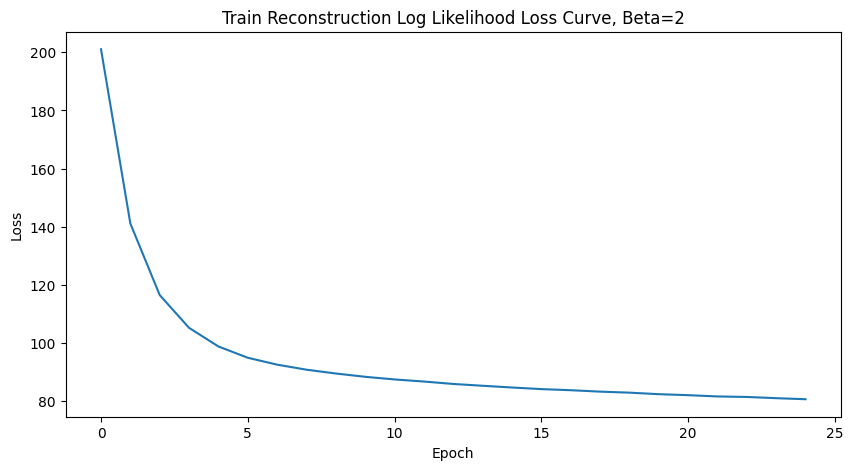

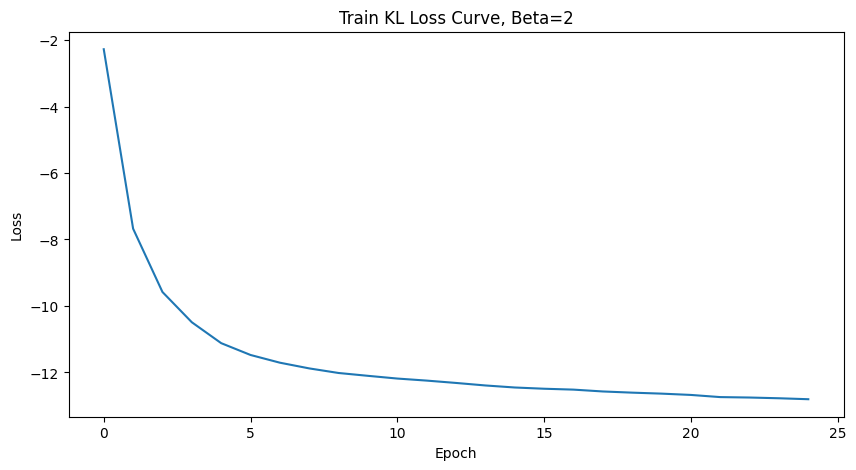

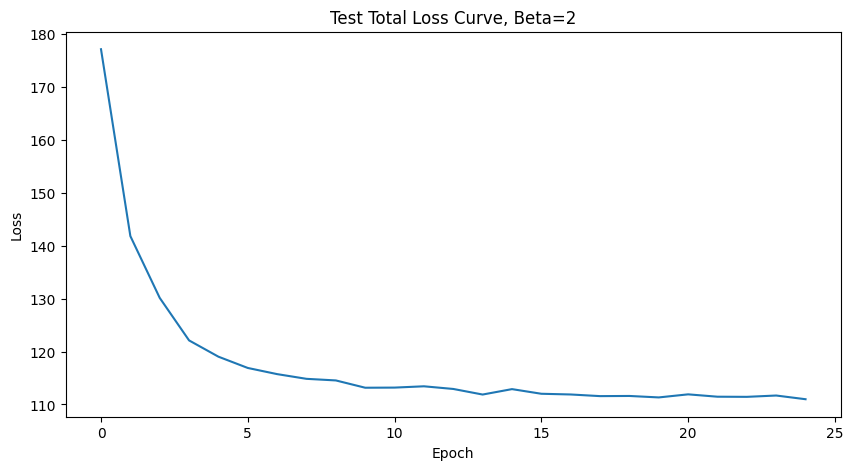

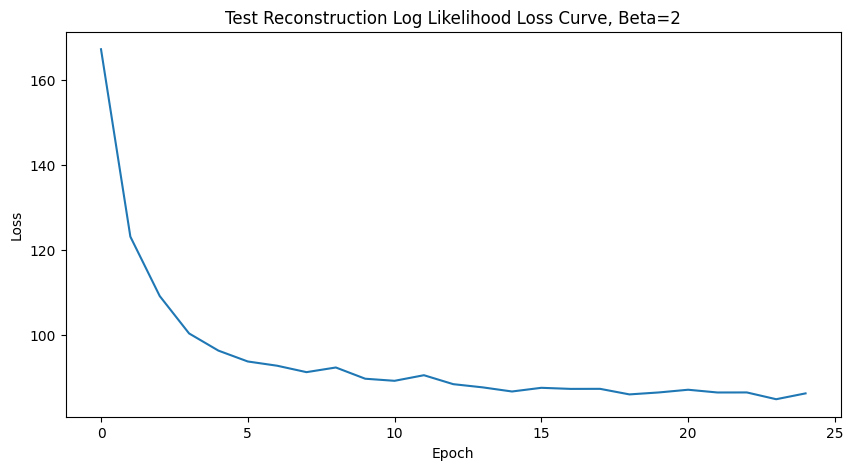

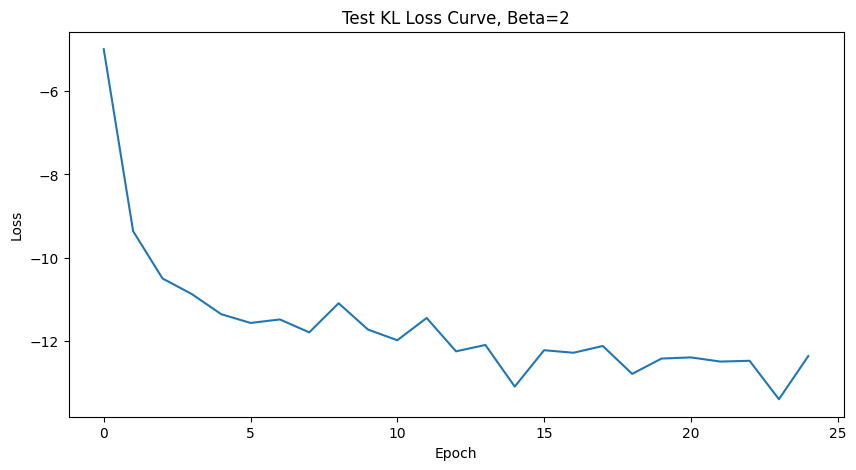

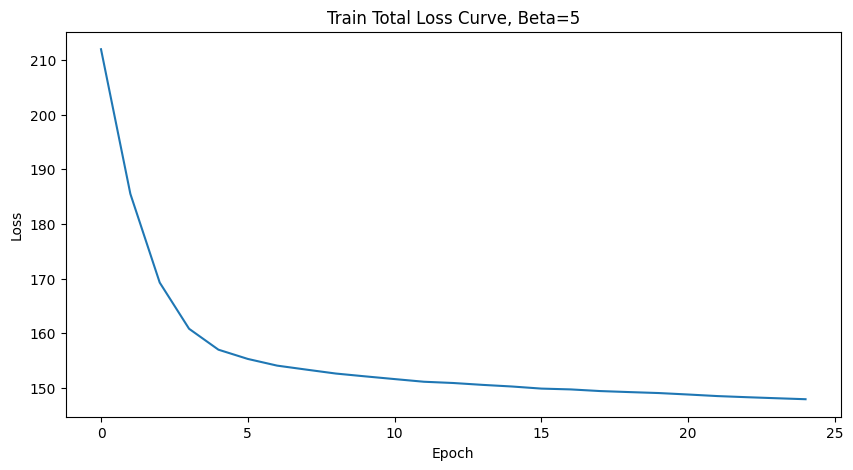

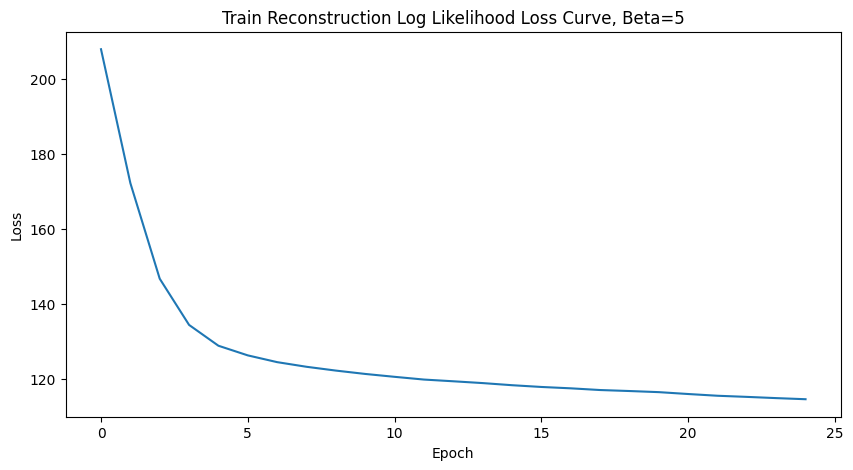

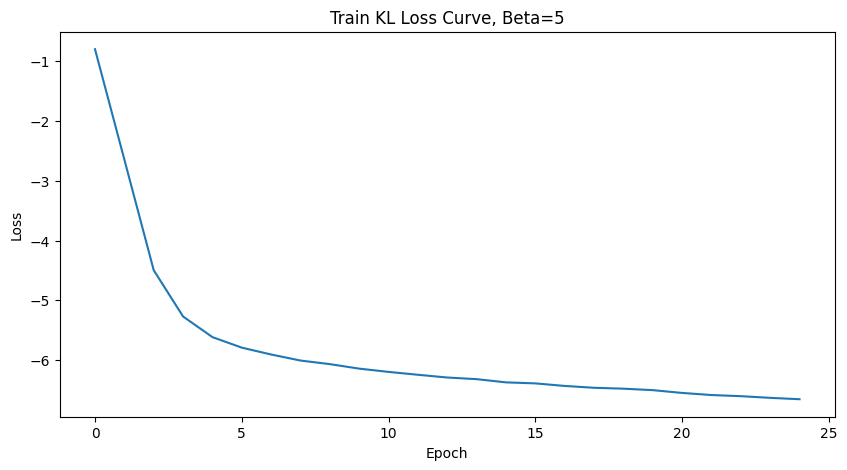

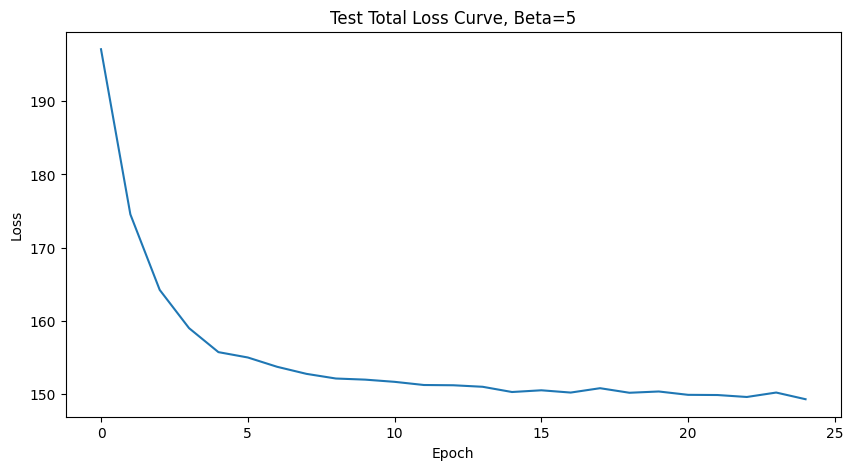

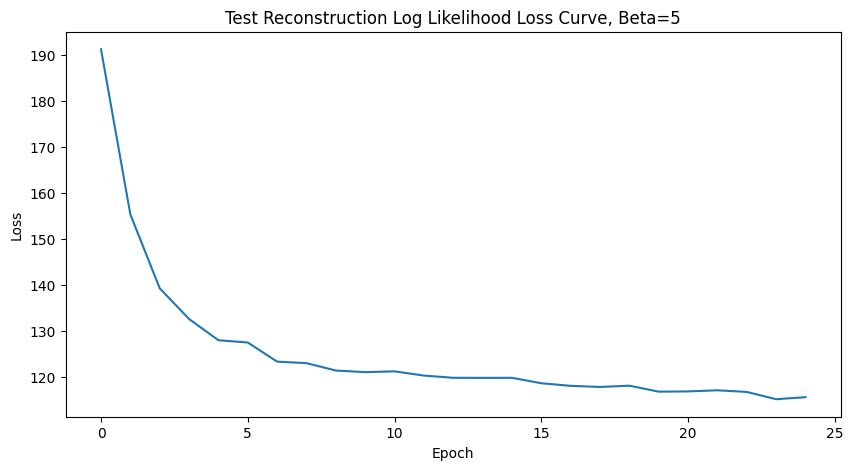

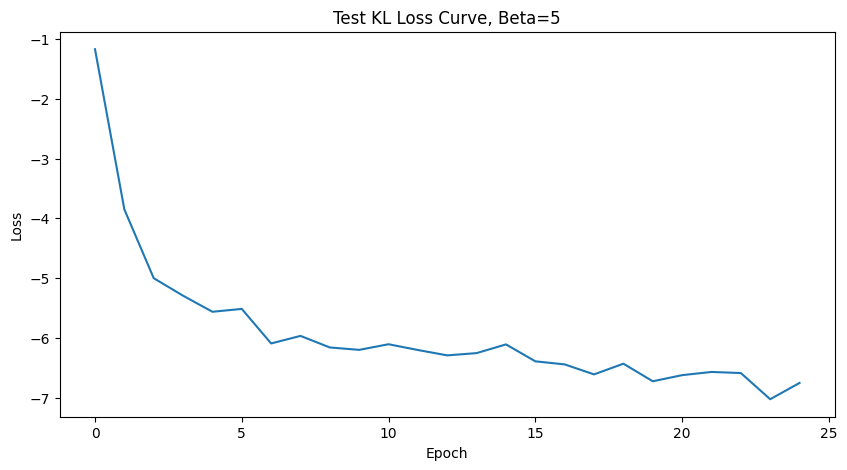

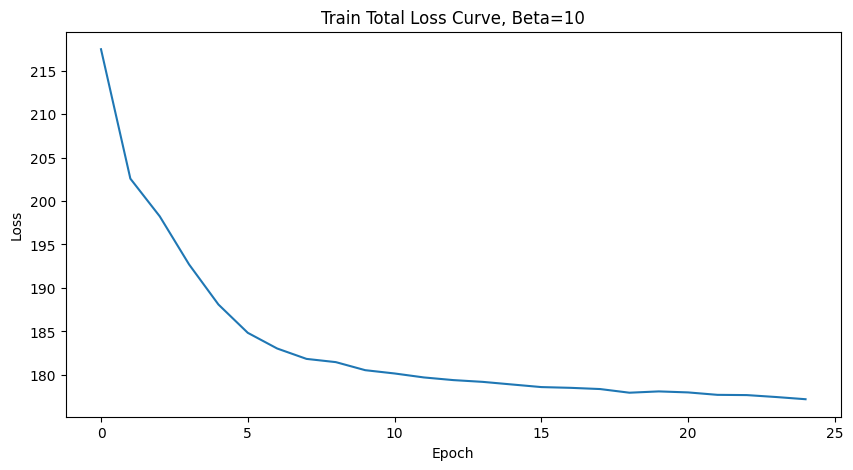

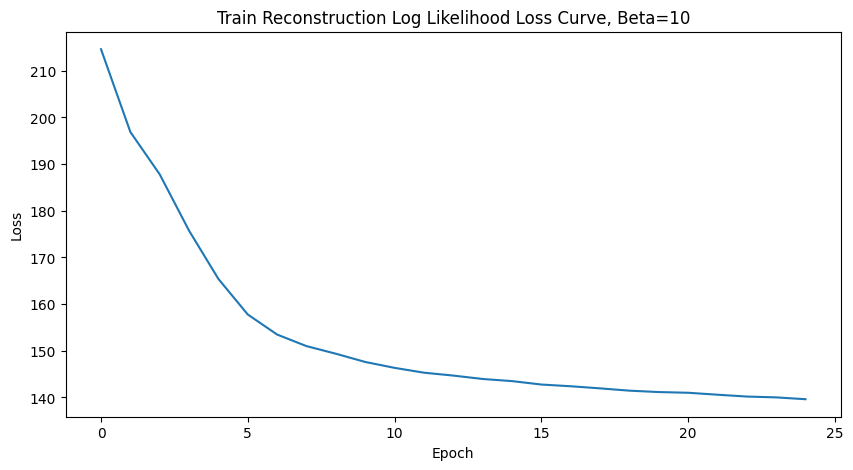

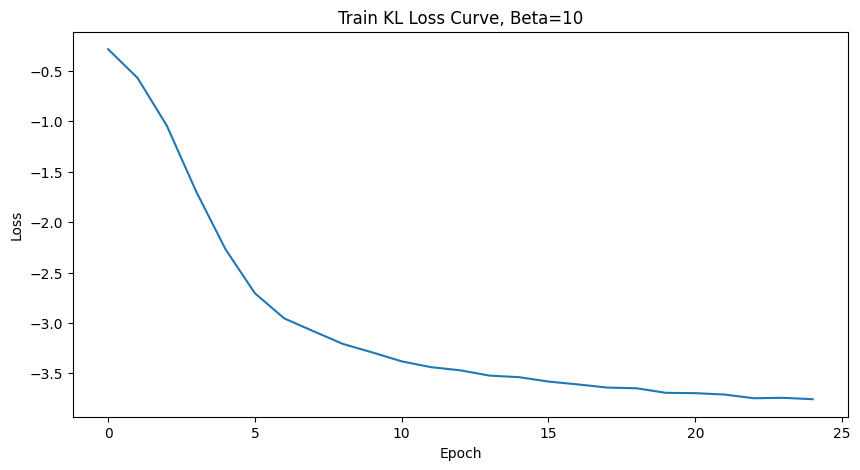

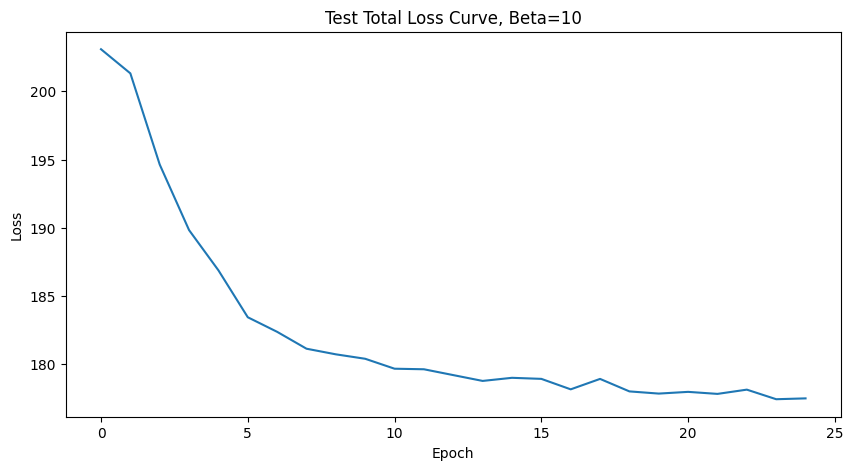

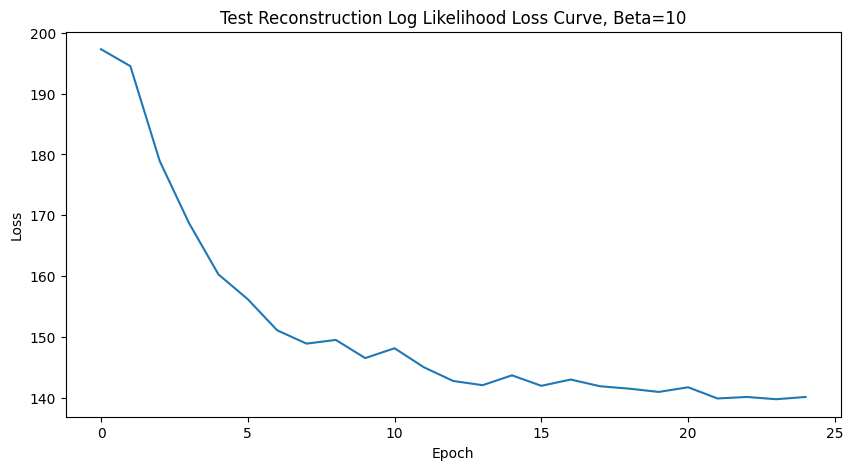

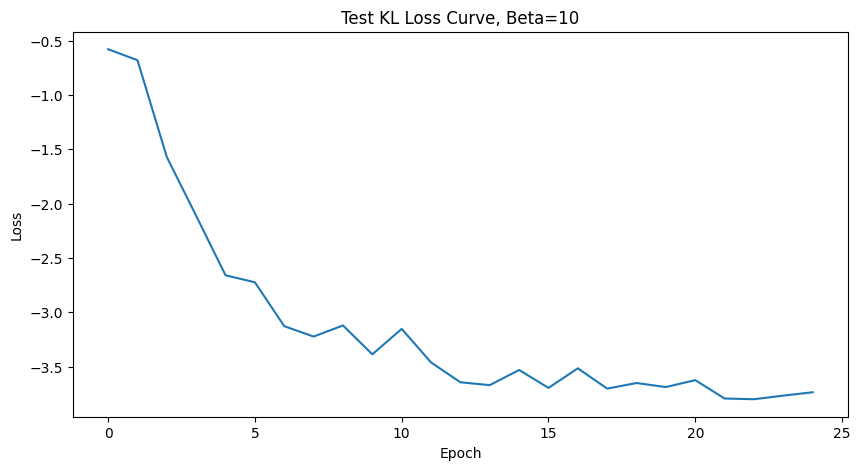

In [10]:
# *CODE FOR PART 1.2a IN THIS CELL*

def plot_losses(filename, beta, train):
    
    with open(filename, 'r') as openfile:
        json_object = json.load(openfile)
        
        epoch_num = len(json_object)
        reconstruction_losses = np.empty(epoch_num)
        kl_divergence_losses = np.empty(epoch_num)
        total_losses = np.empty(epoch_num)
        epochs = np.arange(epoch_num)
        
        for e, epoch_metrics in enumerate(json_object):
            reconstruction_losses[e] = epoch_metrics['reconstruction_loss']
            kl_divergence_losses[e] = epoch_metrics['kl_divergence_loss']
            total_losses[e] = epoch_metrics['total_loss']
            
        plt.figure(figsize=(10, 5), dpi= 100)
        plt.plot(epochs, total_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f'{train} Total Loss Curve, Beta={beta}')
        plt.savefig(f'{content_path}/figures/{train} Total Loss Curve, Beta={beta}.png')
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 100)
        plt.plot(epochs, reconstruction_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f'{train} Reconstruction Log Likelihood Loss Curve, Beta={beta}')
        plt.savefig(f'{content_path}/figures/{train} Reconstruction Log Likelihood Loss Curve, Beta={beta}.png')
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 100)
        plt.plot(epochs, kl_divergence_losses, label='KL Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f'{train} KL Loss Curve, Beta={beta}')
        plt.savefig(f'{content_path}/figures/{train} KL Loss Curve, Beta={beta}.png')
        plt.show()
        


for current_beta in betas:
    plot_losses(f'{content_path}/plots/vae/loss_curves/train_losses_beta_{current_beta}.json', current_beta, "Train")
    plot_losses(f'{content_path}/plots/vae/loss_curves/test_losses_beta_{current_beta}.json', current_beta, "Test")
        

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


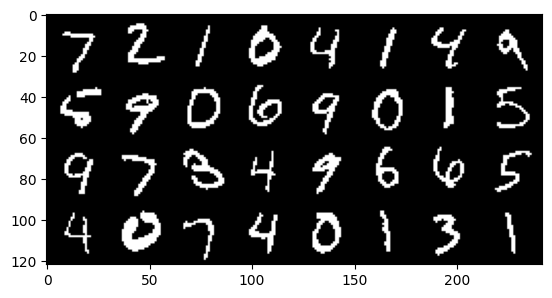

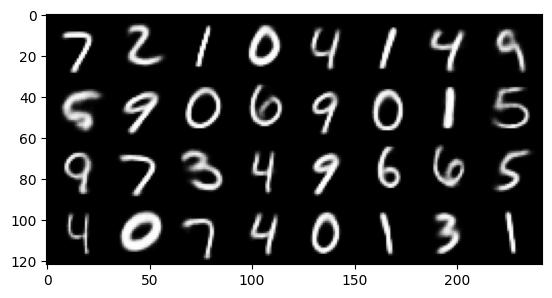

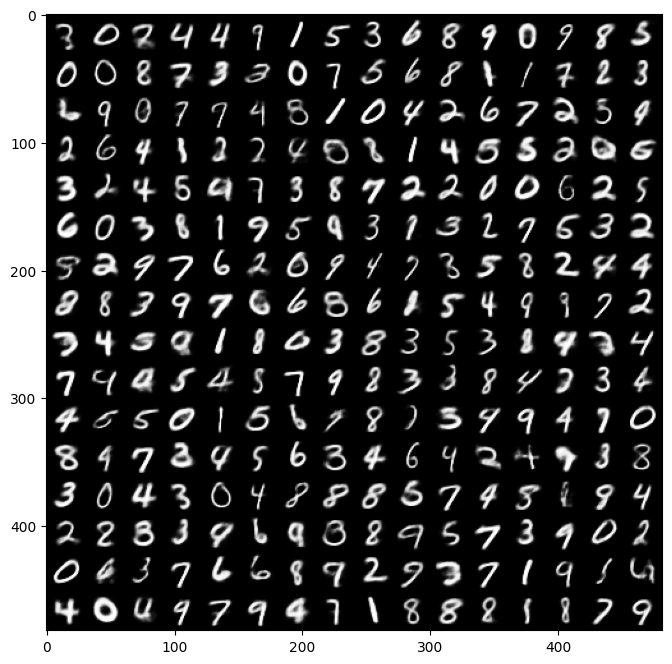

In [18]:
# *CODE FOR PART 1.2b IN THIS CELL*

# Load Pretrained model weights.
loaded_model = torch.jit.load(f'{content_path}/CW_VAE/VAE_model.pth')
model.load_state_dict(loaded_model.state_dict())

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, _, _  = model.forward(fixed_input)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)


### Discussion
Provide a brief analysis of your loss curves and reconstructions:
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable?
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)?
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

As expected, as the number of epochs increase, both the log-likelihood loss as well as the KL loss decrease. This behaviour is desirable for a model that is learning, and we see, both on the training and test set plots the the two terms balance each other out, resulting in well-constructed images for our chosen value of beta = 2. 

When varying the beta value, we notice at beta = 0 that the KL loss does not exhibit the standard desired behaviour, which is expected as the term is unused in our total loss. As we increase beta, we notice that although the total losses are lower for smaller values, the resulting images are not necessarily better. This is due to the KL term not being able to balance the reconstruction loss term enough.

As we increase beta higher than the optimal value of 2 however, we begin observing posterior collapse. Posterior collapse represents the phenomenon of the variational distribution used for inference, or posterior, collapsing to a single point, often matching the prior distribution. As beta is increased to values over 10, the KL term overpowers the reconstruction loss and leads to this collapse. When this phenomenon occurs, we notice the generated images become similar to one another, lacking diversity, as our model predicts the same latent representation.


---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn.

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
!pip install scikit-learn

In [7]:
# *CODE FOR PART 1.3a IN THIS CELL
from sklearn.manifold import TSNE

def get_tsne_embeddings(loader, model, iterations=300):
    # get the latent features with corresponding labels
    model.eval()
    latent_features = np.empty((0,latent_dim))
    labels = np.empty(0)

    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            z, _ = model.encode(data)
            latent_features = np.vstack([latent_features, z.cpu().detach().numpy()])
            labels = np.hstack([labels, label.numpy()])

    #preform TSNE
    tsne = TSNE(n_components=2, random_state=1000, init='pca', verbose=0, perplexity=40, n_iter=iterations)
    z_embedded = tsne.fit_transform(latent_features)
    return z_embedded, labels

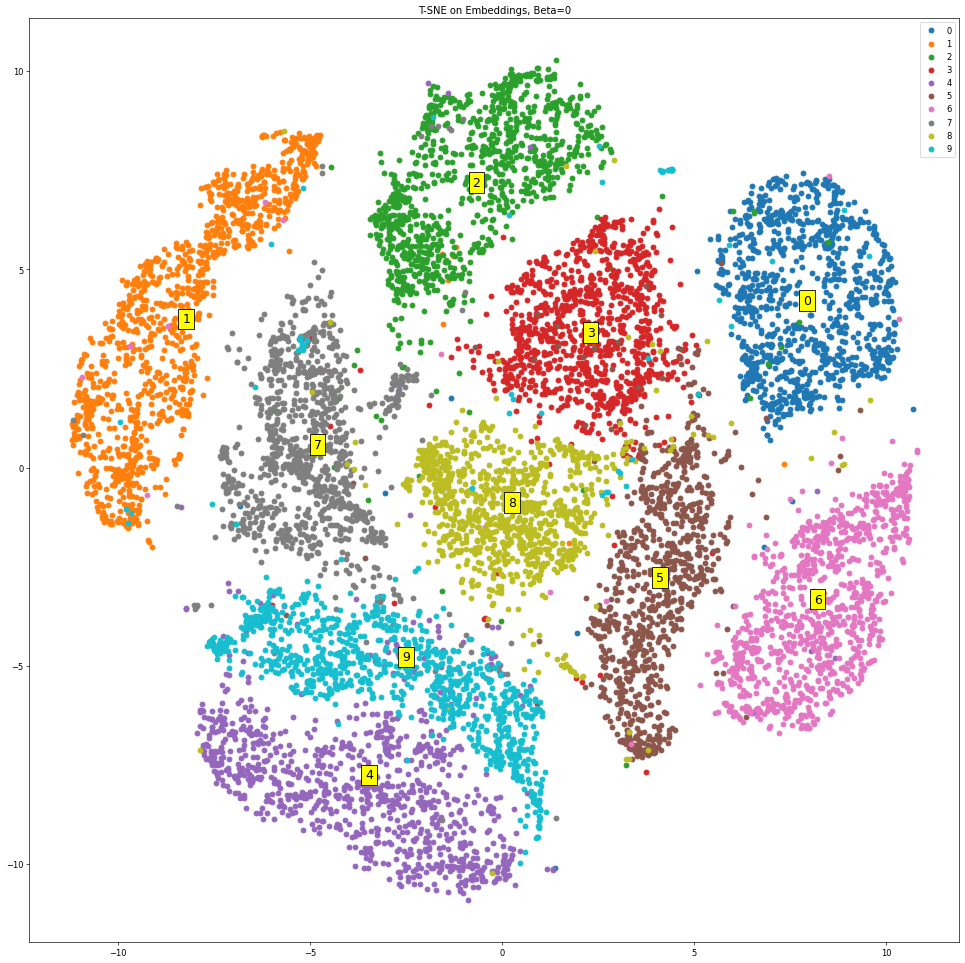

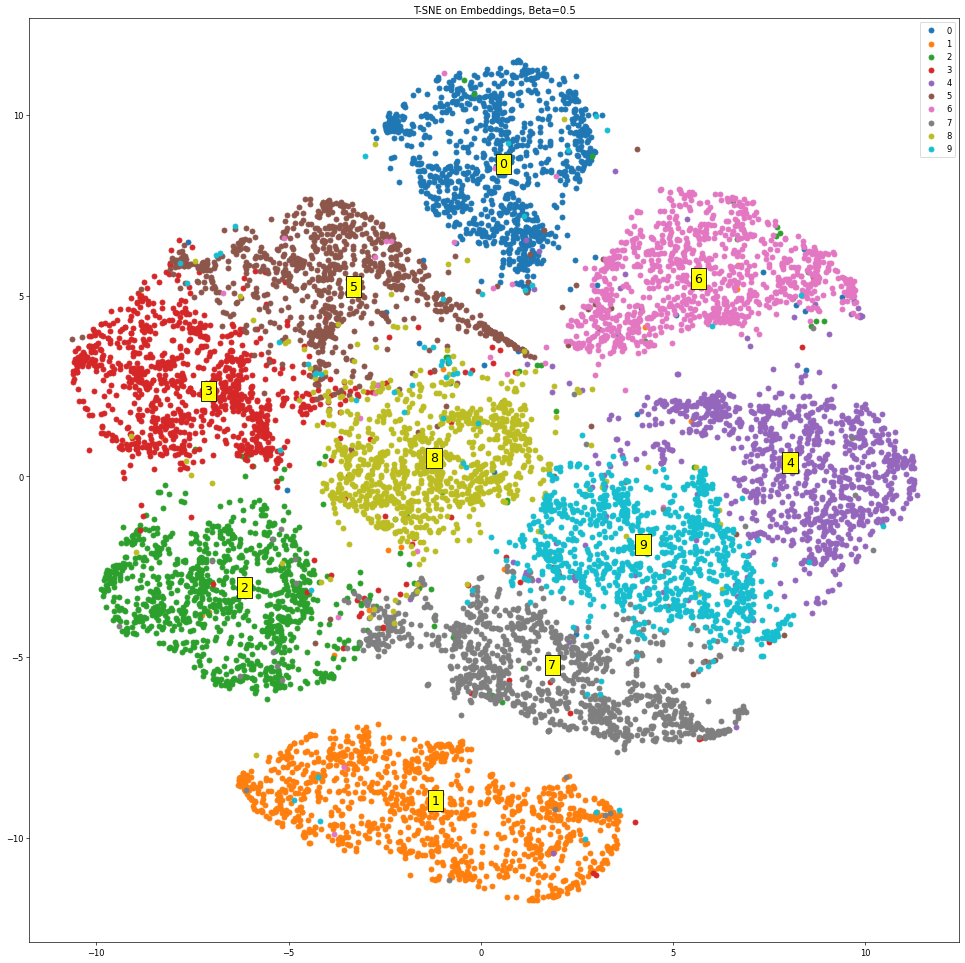

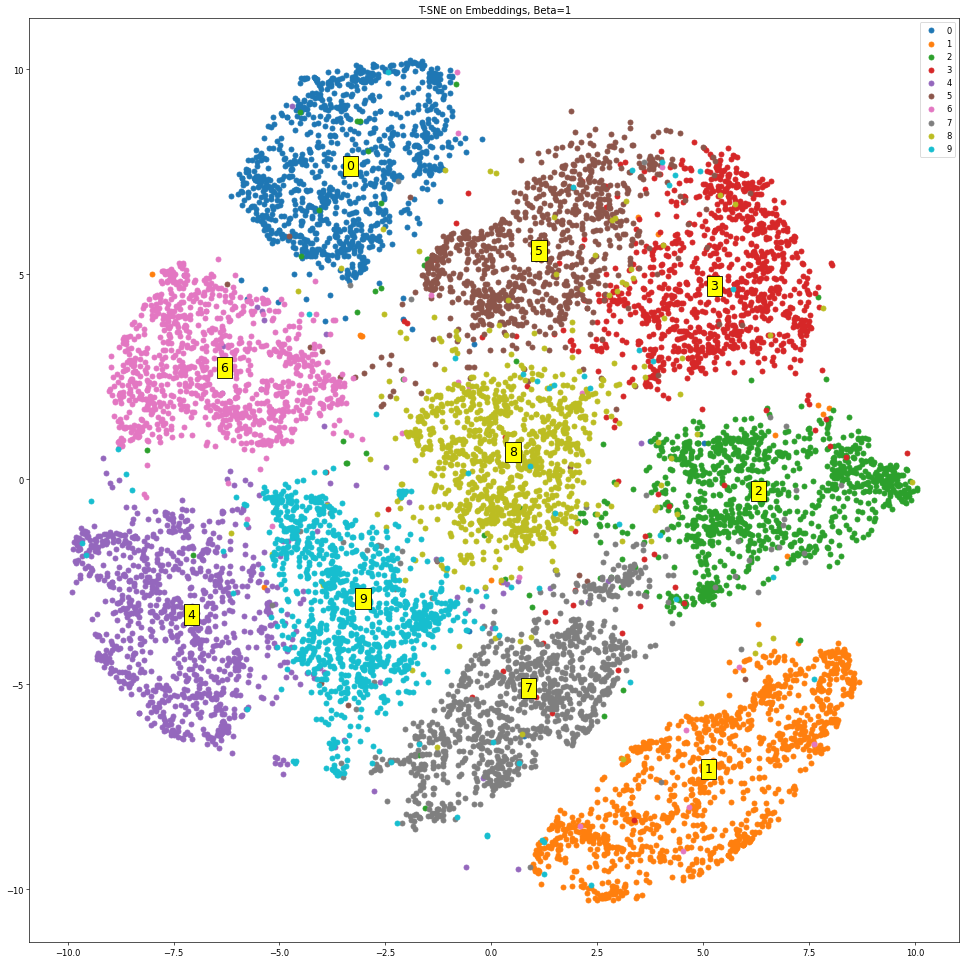

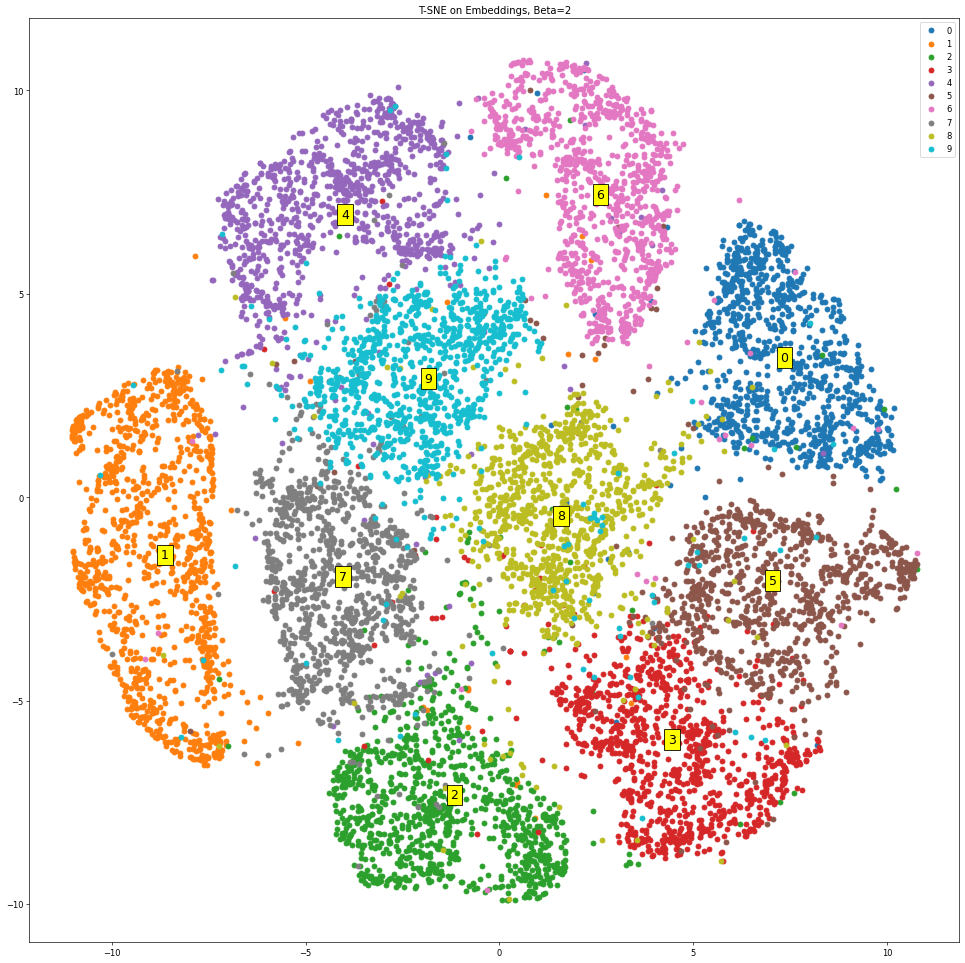

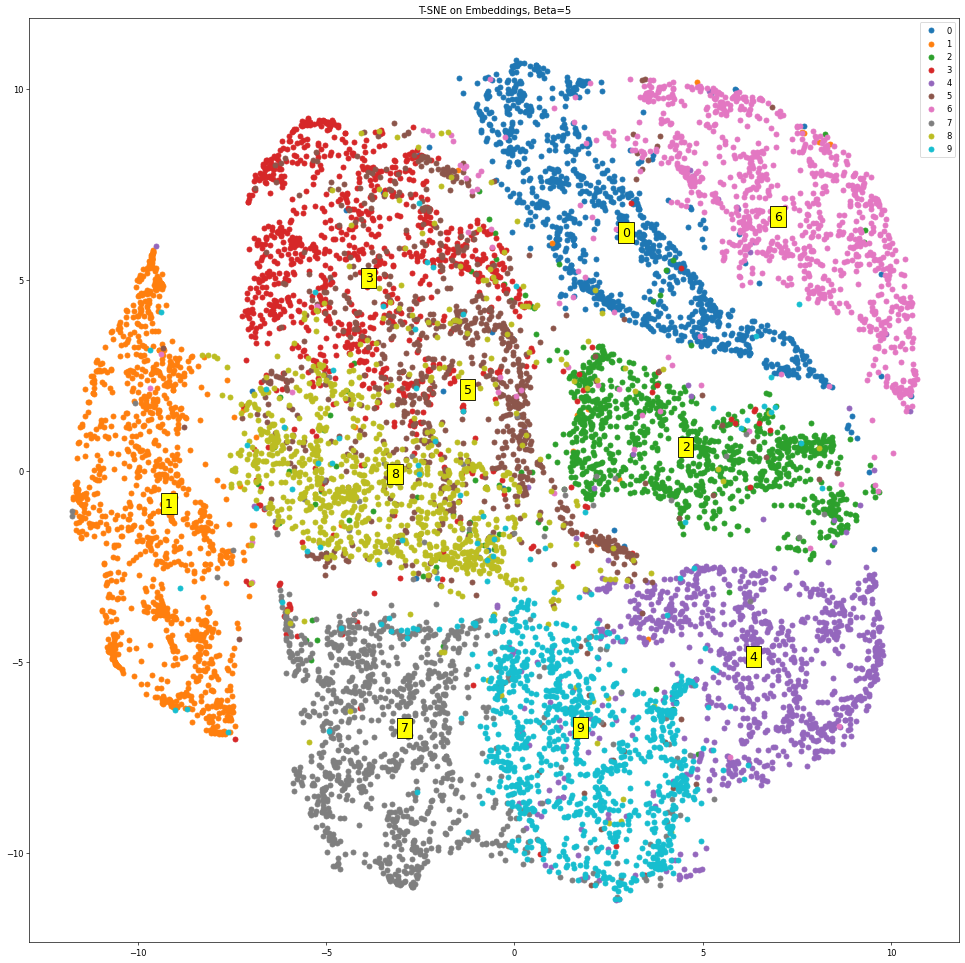

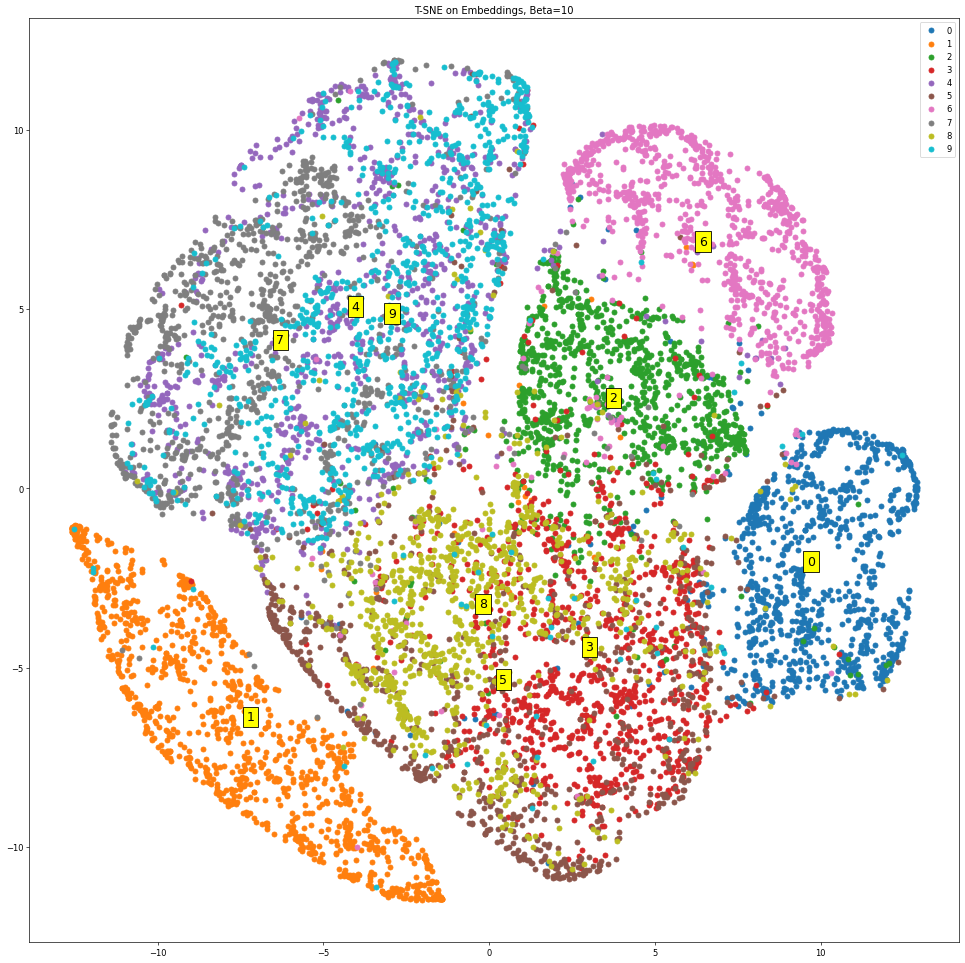

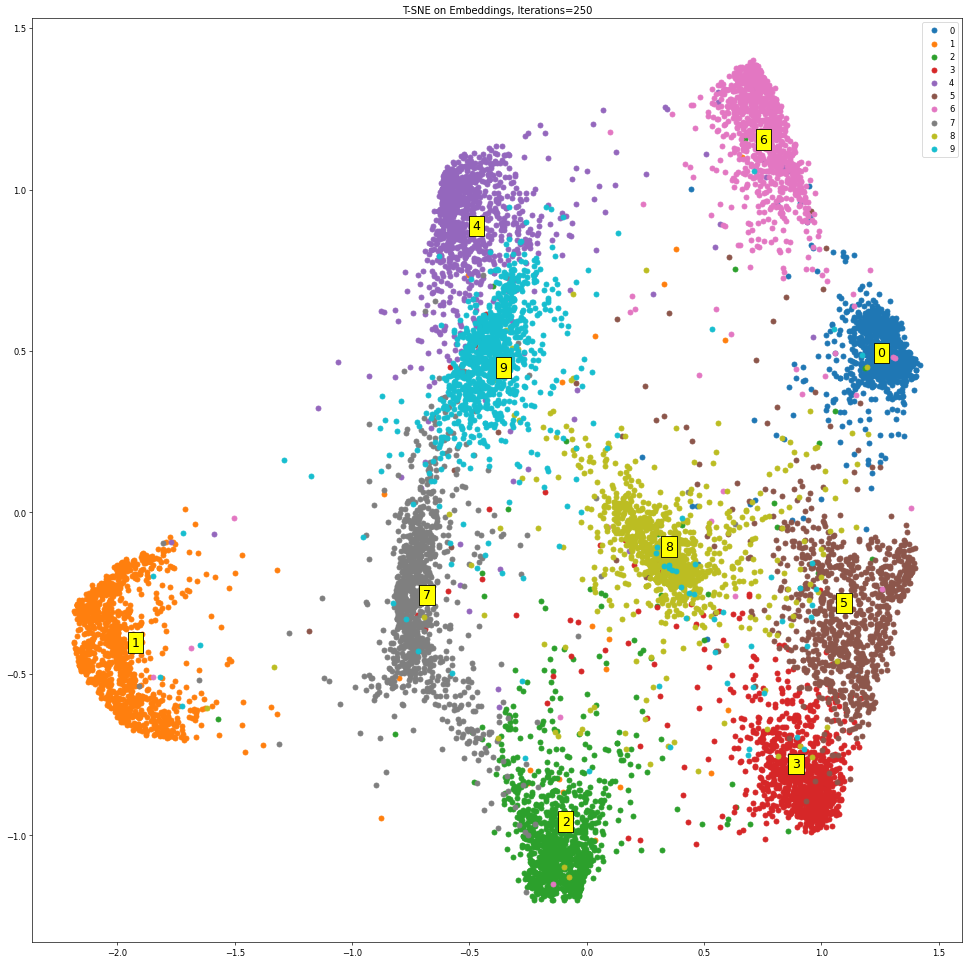

' Inputs to the function are\n        z_embedded - Embedded X, Y positions for every point in test_dataloader\n        test_dataloader - dataloader with batchsize set to 10000\n        num_points - number of points plotted (will slow down with >1k)\n'

In [10]:
# Interactive Visualization - Code Provided
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)

# Custom Visualizations
def plot_tsne_static(z_embedded, labels, title, save_flag=False):
    plt.figure(figsize=(20, 20), dpi= 60)
    col_map = plt.get_cmap("tab10").colors

    for i in range(10):
        x = z_embedded[labels == i, 0]
        y = z_embedded[labels == i, 1]
        plt.scatter(x, y, label = f'{i}')
        plt.text(x=np.mean(x), 
                 y=np.mean(y), 
                 s=f'{i}', 
                 size=15,
                 bbox=dict(boxstyle="square", facecolor='yellow'))

    plt.title(title)  
    plt.legend()
    if save_flag:
        plt.savefig(f'figures_vae/{title}.png')        
    plt.show()

for current_beta in betas:
    # Load Pretrained model weights.
    loaded_model = torch.jit.load(f'{content_path}/plots/vae/VAE_model_{current_beta}.pth')
    model.load_state_dict(loaded_model.state_dict())
    z_embedded, labels = get_tsne_embeddings(test_dataloader, model)
    plot_tsne_static(z_embedded, labels, f"T-SNE on Embeddings, Beta={current_beta}")

loaded_model = torch.jit.load(f'{content_path}/plots/vae/VAE_model_2.pth')
model.load_state_dict(loaded_model.state_dict())
z_embedded, labels = get_tsne_embeddings(test_dataloader, model, iterations=250)
plot_tsne_static(z_embedded, labels, f"T-SNE on Embeddings, Iterations=250")

# Load Pretrained model weights.
loaded_model = torch.jit.load(f'{content_path}/CW_VAE/VAE_model.pth')
model.load_state_dict(loaded_model.state_dict())

z_embedded, labels = get_tsne_embeddings(test_dataloader, model)

""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
#plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


### Discussion
What do you observe? Discuss the structure of the visualized representations.
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

The T-SNE visualisation allows us to see high dimensional latent features in a 2-dimensional image, which allows us to understand roughly where digits lie within the latent space. In our beta = 2 visualisation seen above, we see data points representing the same digits be clustered together, showing that the model understands the grouping of digits well. In this representation, we see these clusters exhibit clear boundaries, but some outliers are still present, such as between the 7 and the 2, which showcase some imperfections in the model.

As we increase beta, we see these clusters begin merging together, offering a visualisation of the posterior collapse phenomenon mentioned previously. With lower values of beta, although the clusters are clearly present, they form irregular shapes within the latent space, and are much more dense, suggesting a lack of disentanglement. 

The T-SNE visualisations are on the whole quite reliable, allowing us to visualise behaviours that we were in fact expecting from the theory and loss curves above. However, this visualisation method is quite sensitive to its parameters and requires a high level of tuning to produce the desired outcomes. For example, when reducing the number of iterations to 250, the visualisation changes drastically, with clusters being much smaller, giving a skewed representation of the latent space. Therefore, T-SNE must be carefully tuned when utilised, and likely be most useful as a confirmation of theoretical hypotheses, or other forms of empirical evidence such as loss curves and generated images.


## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


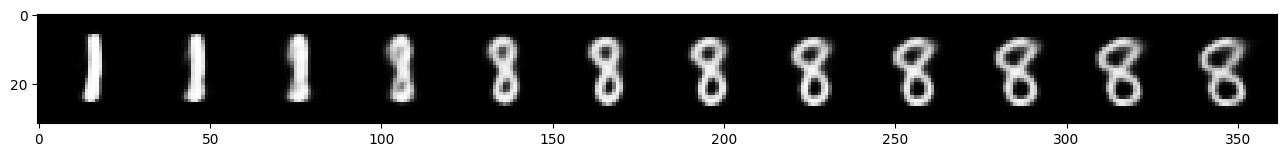

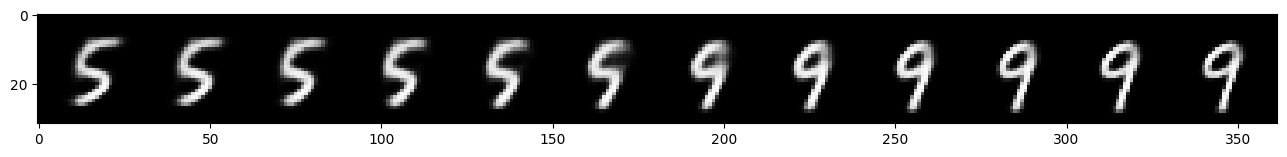

In [19]:
# CODE FOR PART 1.3b IN THIS CELL

loaded_model = torch.jit.load(f'{content_path}/CW_VAE/VAE_model.pth')
model.load_state_dict(loaded_model.state_dict())

def show_interpolation(x_1, x_2, num):
    
    with torch.no_grad():

        mu_1, logvar_1 = model.encode(x_1.to(device))
        mu_2, logvar_2 = model.encode(x_2.to(device))
        z_1 = model.reparametrize(mu_1, logvar_1)
        z_2 = model.reparametrize(mu_2, logvar_2)
        interpolation_values = np.linspace(0,1,num=num)
        latent_features = torch.tensor([]).to(device)

        # Interpolation
        for i in range(len(interpolation_values)):
            z = interpolation_values[i] * z_1 + (1-interpolation_values[i]) * z_2 
            latent_features = torch.cat((latent_features, z), 0)

        samples = model.decode(latent_features)
        samples = samples.cpu()
        samples = make_grid(denorm(samples), nrow=num, padding=2, normalize=False,
                                   scale_each=False, pad_value=0)
        plt.figure(figsize = (16,16))
        show(samples)

test_dataloader = DataLoader(test_dat, batch_size=100, shuffle=False)
test_data, test_labels = next(iter(test_dataloader))

x_1 = torch.FloatTensor(test_data[84]).reshape(1,1,28,28) # 8
x_2 = torch.FloatTensor(test_data[14]).reshape(1,1,28,28) # 1

show_interpolation(x_1, x_2, 12)

x_1 = torch.FloatTensor(test_data[12]).reshape(1,1,28,28) # 9
x_2 = torch.FloatTensor(test_data[23]).reshape(1,1,28,28) # 5

show_interpolation(x_1, x_2, 12)

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

In our interpolation, we observe a smooth transition between digits 1 and 8 at the top, and digits 5 and 9 at the bottom. The digits are all clear at the start and end of the transitions, and form a sensible transition in between them. Although our T-SNE visualisation does not place these digits close to each other, we do observe some outliers from the 8 cluster present in the 1 cluster and some outliers from the 9 cluster present in the 5 cluster. Because of this, it is safe to say the model has learnt the transition between these two pairs of digits, likely neighbouring in latent space, and having some data points which fit both clusters, or more precisely the transition between them, which allows for that to be represented in the images above.

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with:

- your best trained model (which we will be able to load and run),
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse),
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case.
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse.

## Part 2.1 (30 points)
**Your Task**:

a. Implement the DCGAN architecture.

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.5, 0.5, 0.5]) #std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions.
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`).
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [14]:
batch_size =  128 # change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set:

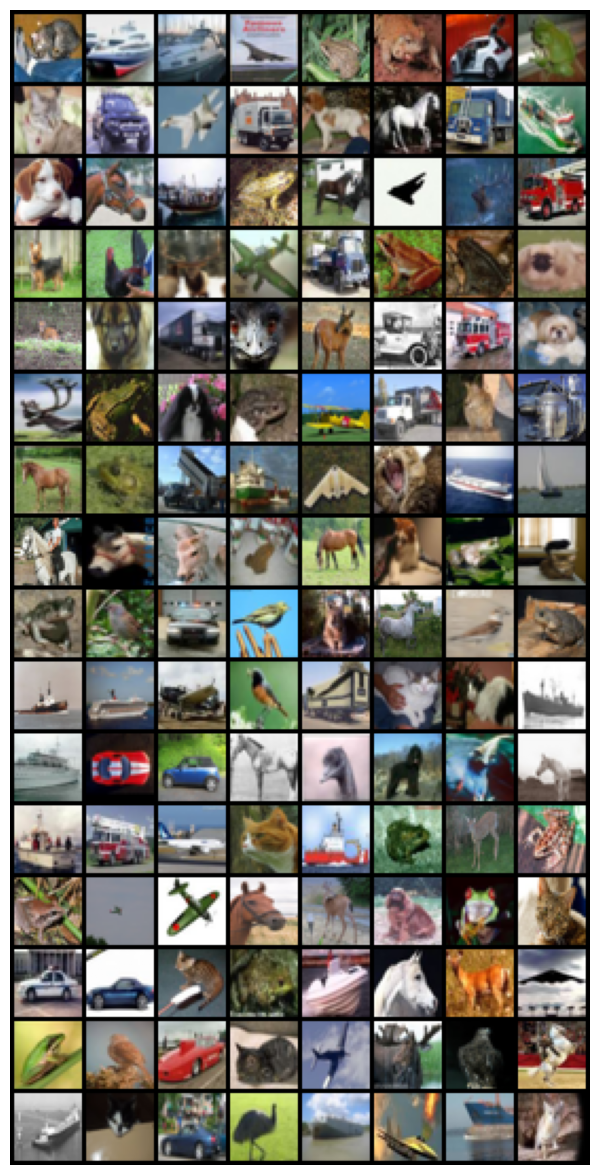

In [15]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [16]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 100 
learning_rate = 2e-4
latent_vector_size = 100

# Other hyperparams
features_g = 32 #64
features_d = 32 #64
channels_img = 3

In [17]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        self.net = nn.Sequential(
            self._block(latent_vector_size, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 4,
                channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), ##
        )
    
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.net(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.net = nn.Sequential(
            self._block(channels_img, features_d, 4, 2, 1),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            nn.Conv2d(features_d * 4, 1, kernel_size=4, stride=2, padding=0), 
            nn.Sigmoid()
        )
        
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.net(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [19]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))


Total number of parameters in Generator is: 3448579
Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)


Total number of parameters in Discriminator is: 167873
Discriminator(
  (net)

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [20]:
# You can modify the arguments of this function if needed
def loss_function(out, label):
    criterion = nn.BCELoss(reduction='mean')
    loss = criterion(out, label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [21]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [22]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [46]:
train_losses_G = []
train_losses_D = []

model_G.train()
model_D.train()

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            
            real_cpu = data[0].to(device)
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            fake = model_G(noise)
            
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            
            # train with real
            
            disc_real = model_D(real_cpu).reshape(-1)
            D_x = disc_real.mean().item()
            loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real))
            
            # train with fake
            
            disc_fake = model_D(fake).reshape(-1)
            D_G_z1 = disc_fake.mean().item()
            loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake))
            
            errD = loss_disc_real + loss_disc_fake
            train_loss_D += errD.item()
            
            model_D.zero_grad()
            errD.backward(retain_graph=True)
            optimizerD.step()
            
            # (2) Update G network: maximize log(D(G(z)))
            
            output = model_D(fake).reshape(-1)
            D_G_z2 = output.mean().item()
            
            errG = loss_function(output, torch.ones_like(output))
            train_loss_G += errG.item()
            
            model_G.zero_grad()
            errG.backward()
            optimizerG.step()
            
            
            

            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 99: 100%|██████████| 391/391 [00:30<00:00, 12.94batch/s, D_G_z=0.396/0.377, D_x=0.627, Loss_D=1.05, Loss_G=1.07]


## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=18aWqRAnAVTRDY52y1yHSCdqSxUFRKOS9" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1ymO2-jGAvWeUR2kaj_LxQcGYF1RWNRnw" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=13SW62ekW32NMYtfcdm_dCJJ3ZMOZEZAJ" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p>
</td>
</tr></table>

### Generator samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


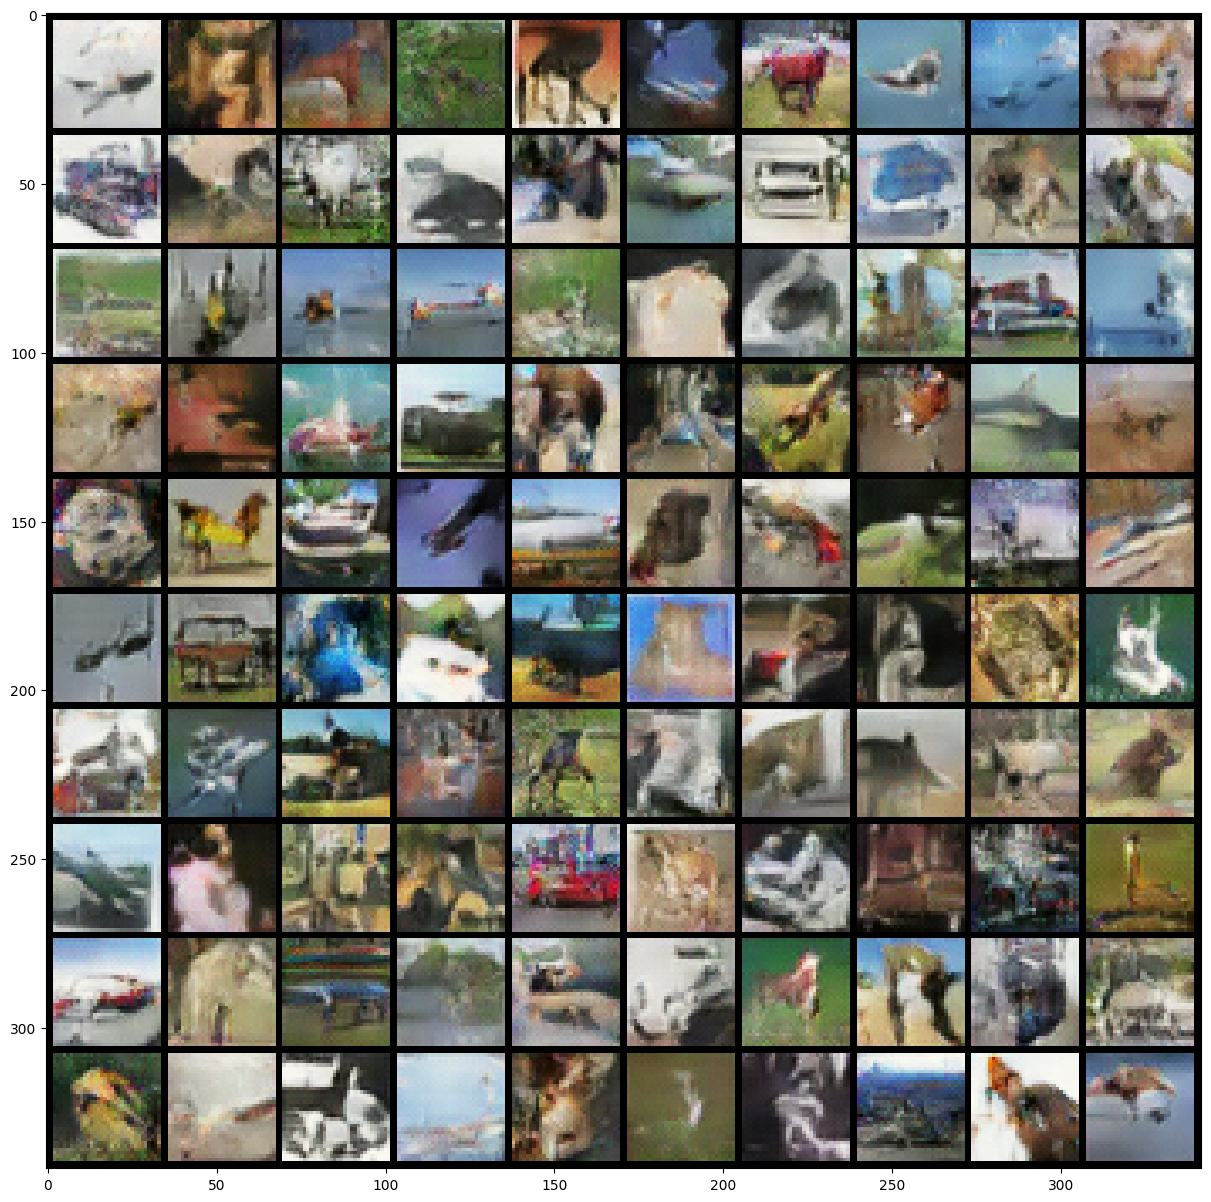

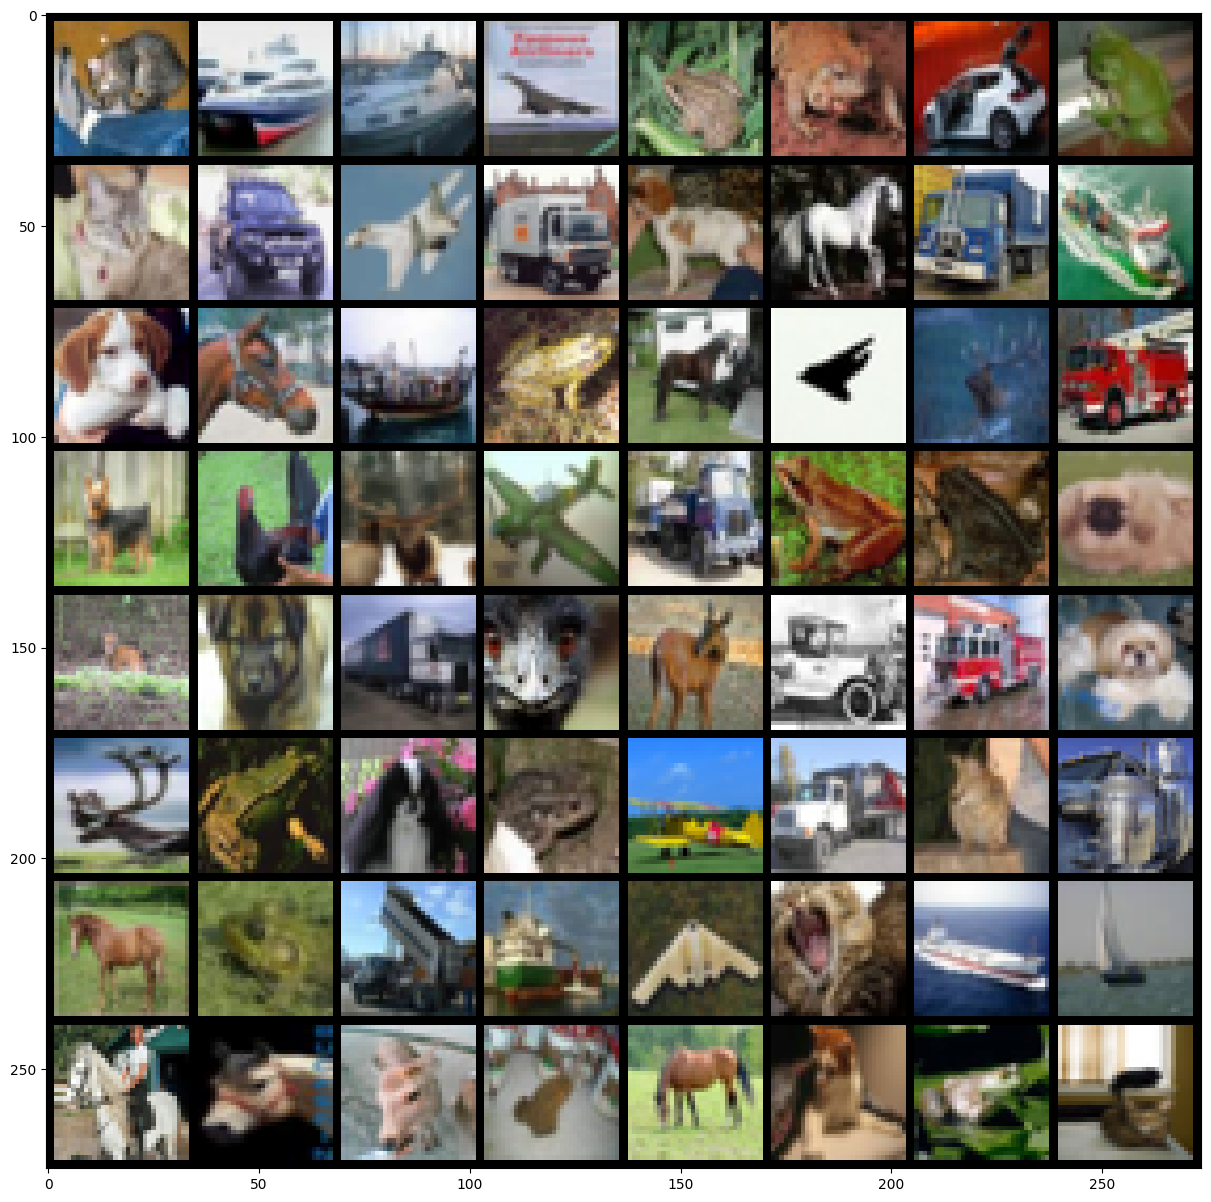

In [47]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

In [48]:
def save_gan_loss_curve(name, array):
    loss_curves_path = f'{content_path}/plots/gan/loss_curves/{name}'

    with open(f'{loss_curves_path}.json', 'w') as outfile:
        json.dump(array, outfile)
        
save_gan_loss_curve("gen_losses_iter3", train_losses_G)
save_gan_loss_curve("disc_losses_iter3", train_losses_D)

In [24]:
def plot_gan_losses(gen_file, disc_file, title):
    
    with open(gen_file, 'r') as openfile:
        gen_object = json.load(openfile)
    
    with open(disc_file, 'r') as openfile:
        disc_object = json.load(openfile)
        
    epoch_num = len(gen_object)
    gen_losses = np.empty(epoch_num)
    disc_losses = np.empty(epoch_num)
    epochs = np.arange(epoch_num)
    
    for e in range(epoch_num):
        gen_losses[e] = gen_object[e]
        disc_losses[e] = disc_object[e]
    
    plt.figure(figsize=(10, 5), dpi= 100)
    plt.plot(epochs, gen_losses, label='Generator Loss')
    plt.plot(epochs, disc_losses, label='Discriminator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.savefig(f'{content_path}/figures/{title}.png')
    plt.show()
        

**Your Answer**

To begin designing our GAN architecture, we utilised the original DCGAN paper and implemented the architecture described there.

For the generator, this consisted of blocks that would do a ConvTranspose2d, a BatchNorm2d and a ReLU, with a final transpose convolution and Tanh on the output. For the discriminator this consisted of a Convolution followed by LeakyReLU, then blocks of convolutions, BatchNorm2ds and LeakyReLUs with a final convolution and sigmoid for the output.

However, our input images were of smaller size than those in the original paper, being 32x32 rather than 64x64. This meant we had to remove a block from both the discriminator and generator, to fit the smaller dimensions. We initially chose to remove the last blocks from each.

In this architecture, we used a learning rate of 2e-4, a batch size of 128 and a latent vector size of 100 as described in the paper. We included features_g and features_d as hyperparameters, which, when multiplied by powers of two, represented the number of features given as input and outputs to our layers, as seen in the code. 

![](./figures/gan_orig.png)
![](./figures/gan_orig_loss.png)

When running this base architecture, and examining our output images, we notice clear evidence of mode collapse, having only a few kinds of images generated, as well as no resemblance of the original input images. To tune our network we chose to undertake empirical experiments, changing aspects mentioned in the original paper and examining the loss curves and images generated with each epoch.

The first aspect which we played around with was the batch normalisation applied to the layers. Removing this normalisation, as the paper suggested, had undesirable effects, leading to more mode collapse, as the theory would indicate. However, what was found to eliminate the mode collapse was adding a batch normalisation layer to the input of the discriminator. Although this contradicts the suggestion of the paper, empirically it was shown to improve results.

![](./figures/gan_batchnorm.png)
![](./figures/gan_batchnorm_loss.png)

As seen below the final images are much closer to the desired output, however they are less saturated than the input images. To tackle this problem, we undertook two steps that together achieved images much closer to the inputs. 

The first of these steps was increasing the standard deviation within the normalisation function to 0.5. As the pixels within the CIFAR dataset are skewed, being over 1 post normalisation, the Tanh layer applied to our output is not able to produce pixels as intense as desired. However, by updating the normalisation function, this could be rectified.

![](./figures/gan_std_higher.png)
![](./figures/gan_std_higher_loss.png)

This step alone however did not solve the problem entirely. When examining the output images across epochs, we notice an unstable learning process, with images changing drastically from one epoch to the next, and some still retaining saturation issues. This instability is further confirmed by our loss curves. To tackle this issue, we decided to reduce the features_g and features_d hyperparameters from 64 to 32, effectively halving the dimension of each of our layers.

This final step fixed the saturation issue, and somewhat stabilised the learning process, decreasing the variation in the loss across each epoch.

![](./figures/gan_less_features.png)
![](./figures/gan_less_features_loss.png)

Some elements we attempted to tune which did not lead to any improvement were the learning rate and latent vector size, both of which seemed most effective with the values from the original paper. Furthermore, when examining the loss curve, we initially hypothesised that tuning the number of epochs would be beneficial, as we see an increase in the generator loss after around 50 epochs, but when examining the images produced at each epoch, we notice small but relevant improvements in the generated images past the 40 epoch mark and so decided to maintain a 100 epoch run for our final model. 




## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

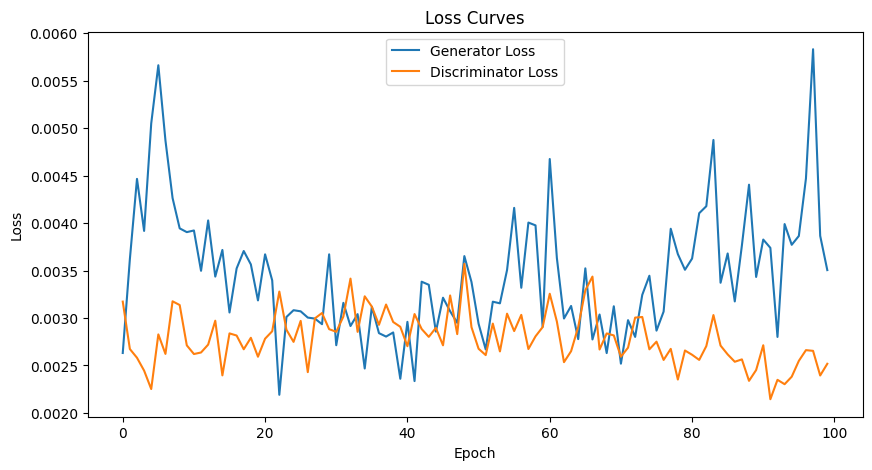

In [25]:
# ANSWER FOR PART 2.2 IN THIS CELL*
plot_gan_losses(f'{content_path}/plots/gan/loss_curves/gen_losses_iter3.json',
                f'{content_path}/plots/gan/loss_curves/disc_losses_iter3.json',
                "Loss Curves"
                )

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

When examining our final loss curves, as mentioned above, we notice the generator loss decrease for the first 40 epochs, then rise back to higher values. We do see, however, that in parallel, the discriminator loss is higher around the 40 epoch mark but decreases until the 100 epoch mark. This may suggest that our generator isn't decreasing in performance, but rather that its improvements are marginal and when compared to the improvements of the discriminator, cause the generator’s loss to increase. The curves still exhibit some levels of instability which could be tackled through further tuning, but may also be a result of the nature of adversarial neural networks, being often more unstable in their loss curves than other neural networks.

## Part 2.3: Understanding Mode Collapse (5 points)
**Your task:**

Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN.

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

In [12]:
# Any additional code

### Discussion


**YOUR ANSWER**

Mode collapse is a phenomenon seen in Grans where the generator produces a similar, limited set of outputs irrespective of the input noise it receives. Within the output images, it manifests through samples which do not resemble the input images, and which are similar to one another, or grouped in a few different categories. We encountered this problem while tuning our network, as seen below.

![](./figures/gan_orig.png)

This problem was largely solved by adding an extra layer of batch normalisation, as doing so helps stabilise gradients and allows for more exploration and learning of complex features. Some theory also suggests adding dropout could also aid with tackling mode collapse, though there is also literature suggesting it would work less well in combination with batch normalisation, and adding dropout did not prove needed in our particular case.




# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably.

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [26]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
ta_data_path = data_path #"../data" # You can change this to = data_path when testing

In [ ]:
!pip install -q torch torchvision

In [27]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [28]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round()
])

def vae_denorm(x):
    return x

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.5, 0.5, 0.5]) 
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def gan_denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

gan_latent_size = 100

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [29]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform,
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [30]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used CNN


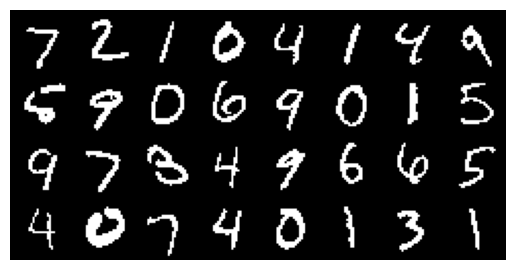

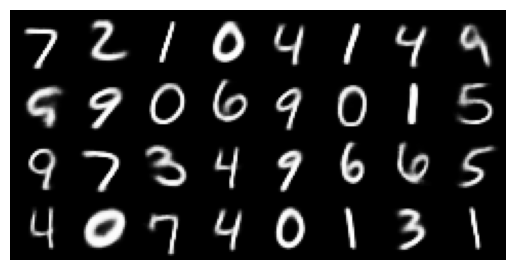

In [31]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 3616452 which is ok


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


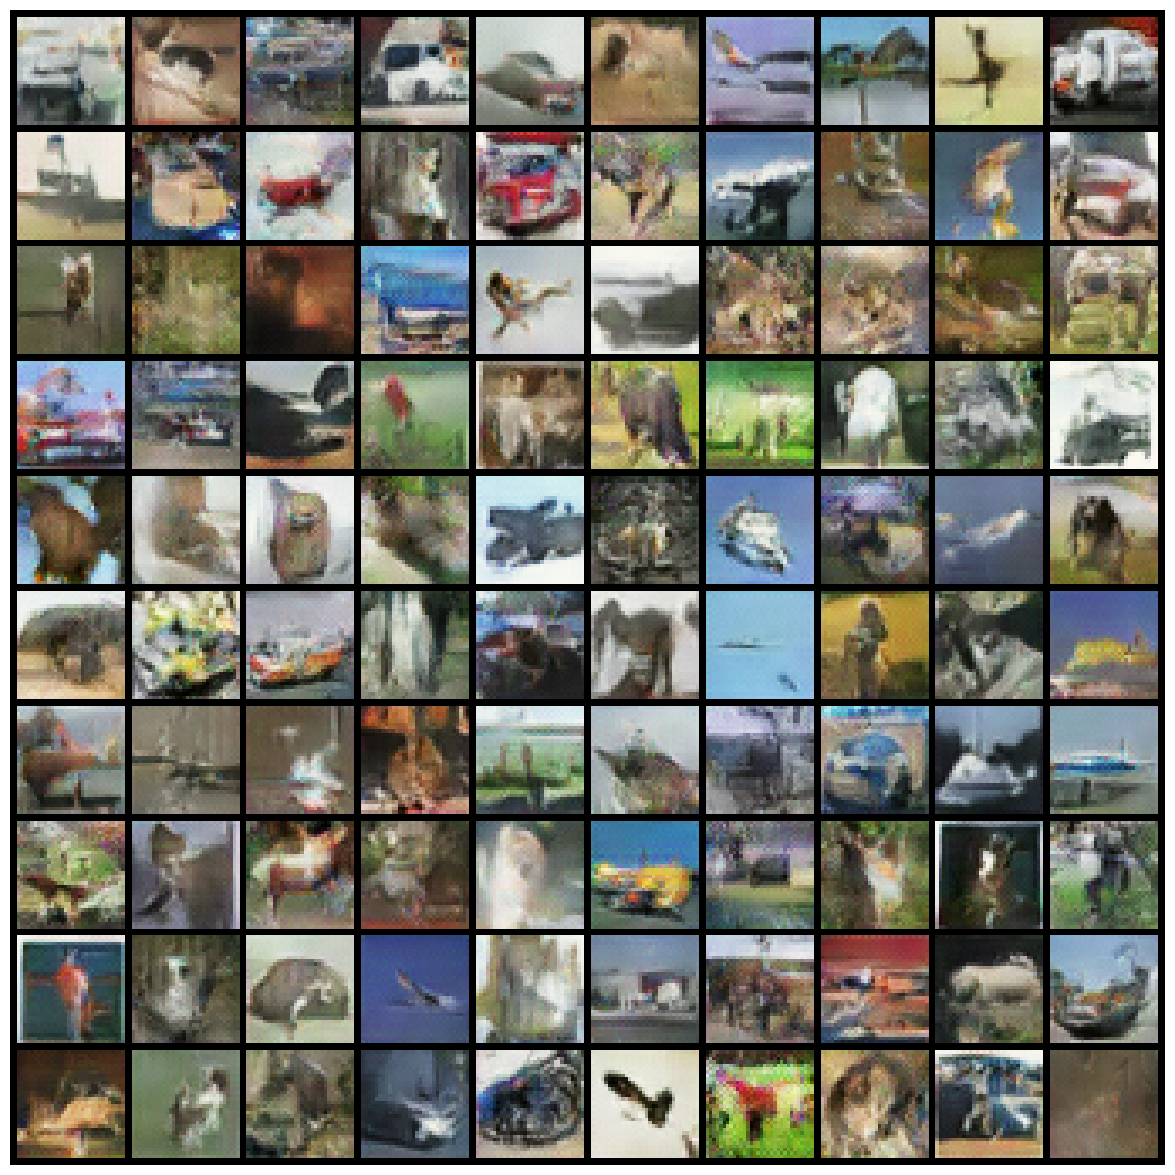

In [32]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False,
                    value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)